# Оценка доступности супермаркетов для жителей ЮАО г. Москвы. Поиск перспективных локаций для открытия нового супермаркета

Задачи проекта: 
- оценить доступность супермаркетов для жителей южного административного округа (ЮАО) города Москвы;
- найти локации, наиболее подходящие для открытия нового супермаркета.

## 1. Импорт нужных библиотек

In [90]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import re
from shapely.geometry import Point, Polygon
import geojson
import h3
import requests
import matplotlib.pyplot as plt
import contextily as ctx
import shapely
import folium
import os
from dotenv import load_dotenv
import numpy as np
import seaborn as sn
import gc

In [3]:
# Активируем режим Copy-on-Write (CoW), который будет применяться по умолчанию в будущих версиях pandas
pd.options.mode.copy_on_write = True

## 2. Загрузка исходных данных

Ниже в таблице приведен перечень исходных данных, которые потребуются нам для решения задачи.

| № | Данные | Описание | Источник | Ссылка на данные| Цель использования |
|:------|:------|:--------|:--------|:--------|:--------|
| 1. |  Границы ЮАО   |  Границы территории ЮАО   |  Проект OpenStreetMap   | https://www.openstreetmap.org/ | Для загрузки исходных данных в экстенте ЮАО |
| 2. |  Районы ЮАО   |  Классификатор районов ЮАО с кодами ОМК ТЕ   |  Портал открытых данных Правительства Москвы   | [Данные на data.mos.ru](https://data.mos.ru/opendata/2039) | Для отбора улиц ЮАО по кодам районов, к которым они относятся |
| 3. |  Границы районов ЮАО   |  Границы районов в составе ЮАО   |  Проект OpenStreetMap   | https://www.openstreetmap.org/ | Для агрегации анализируемых показателей по районам |
| 4. | Супермаркеты Москвы | Точки расположения и характеристики супермаркетов Москвы | Портал открытых данных Правительства Москвы | [Данные на data.mos.ru](https://data.mos.ru/opendata/3304?pageSize=10&pageIndex=0&isDynamic=false&version=1&release=226) | Основной предмет анализа |
| 5. |  Жилые дома Москвы   |  Реестр домов Москвы с указанием жилой площади  |  Фонд развития территорий   | [Данные на фрт.рф](https://xn--80adsazqn.xn--p1aee.xn--p1ai/opendata?gid=2280999&page=2&pageSize=12)  | Для расчета численности жителей дома на основе общей численности жителей района и жилой площади дома |
| 6. |  Численность населения   |  Численность населения по районам Москвы на 01.01.2025 г.   |  Мосстат   | [Страница загрузки на https://77.rosstat.gov.ru/](https://77.rosstat.gov.ru/folder/64634?ysclid=manuswzgup941470547)<br>[Прямая ссылка на файл](https://77.rosstat.gov.ru/storage/mediabank/%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0%20%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B3.%20%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B%20%D0%BF%D0%BE%20%D1%81%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D1%8E%20%D0%BD%D0%B0%201%20%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8F%202025%20%D0%B3%D0%BE%D0%B4%D0%B0%20%D0%B8%20%D0%B2%20%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%BC%20%D0%B7%D0%B0%202024%20%D0%B3%D0%BE%D0%B4(2).doc)| Для расчета численности жителей дома на основе общей численности жителей района и жилой площади дома |
| 7. |  Улицы Москвы   | Классификатор улиц Москвы  |  Портал открытых данных Правительства Москвы | [Данные на data.mos.ru](https://data.mos.ru/opendata/2044) | Для отбора жилых домов из реестра домов, относящихся к улицам ЮАО |
| 8. |  Строения ЮАО   |  Все строения Москвы (не только жилые дома)   |  Проект OpenStreetMap   | https://www.openstreetmap.org/ | Для исключения территорий без строений при выборе локации для нового супермаркета |
| 9. |  Парки ЮАО   |  Парки Москвы   |  Проект OpenStreetMap   | https://www.openstreetmap.org/ | Для исключения парковых зон при выборе локации для нового супермаркета|

### 2.1 Границы ЮАО

Загрузим данные по границам ЮАО с OpenStreetMap с использованием библиотеки osmnx.

In [4]:
# Границы ЮАО
place=["Южный административный округ, Москва, Россия"]
okrug = ox.geocoder.geocode_to_gdf(place)
okrug

geometry  bbox_west  bbox_south  \
0  POLYGON ((37.5698 55.60807, 37.56988 55.60772,...  37.569798   55.566373   

   bbox_east  bbox_north   place_id  osm_type   osm_id        lat        lon  \
0  37.793561   55.729465  181904230  relation  1282181  55.647965  37.644083   

      class            type  place_rank  importance     addresstype  \
0  boundary  administrative          10    0.266756  administrative   

                            name  \
0  Southern Administrative Okrug   

                                        display_name  
0  Southern Administrative Okrug, Moscow, Central...

In [5]:
okrug.loc[0, "name"] = "Южный административный округ"
okrug = okrug[["geometry", "name"]]

In [6]:
okrug.explore()

In [8]:
# Сохраним границы ЮАО в файл
okrug.to_file("./data/processed/okrug_uao.geojson", driver="GeoJSON")

In [9]:
# Сохраним границы ЮАО как объект shapely - он понадобится в дальнейшем для загрузки данных в экстенте ЮАО
okrug_polygon = okrug.loc[0, "geometry"]

In [10]:
# Получим bbox для полигона ЮАО - понадобится в дальнейшем для загрузки данных на ЮАО, когда поддерживается только прямоугольник в качестве экстента загрузки
okrug_bbox = okrug_polygon.bounds
okrug_bbox

(37.5697983, 55.5663727, 37.793561, 55.729465)

### 2.2 Районы ЮАО

Классификатор территориальных единиц Москвы был скачан вручную в виде csv-файла с Портала открытых данных Правительства Москвы: https://data.mos.ru/opendata/2039.

In [13]:
# Загрузим классификатор территориальных единиц Москвы из файла в датафрейм
territory_classifier = pd.read_csv("./data/source/territory_classifier.csv", delimiter=";", header=1)

In [14]:
# Отобразим классификатор целиком
with pd.option_context('display.max_rows', None):
    display(territory_classifier)

Наименование   Код  \
0         Центральный административный округ   100   
1                                район Арбат   101   
2                            Басманный район   102   
3                        район Замоскворечье   103   
4                       Красносельский район   104   
5                            Мещанский район   105   
6                          Пресненский район   106   
7                            Таганский район   107   
8                             Тверской район   108   
9                            район Хамовники   109   
10                            район Якиманка   110   
11           Северный административный округ   200   
12                            район Аэропорт   201   
13                             район Беговой   202   
14                     Бескудниковский район   203   
15                          Войковский район   205   
16                  район Восточное Дегунино   206   
17                         Головинский район   207   
18                         Дмитровский район   208   
19                   район Западное Дегунино   209   
20                             район Коптево   210   
21                        район Левобережный   211   
22                      Молжаниновский район   212   
23                         Савёловский район   213   
24                               район Сокол   214   
25                       Тимирязевский район   215   
26                             район Ховрино   216   
27                         Хорошёвский район   217   
28   Северо-Восточный административный округ   300   
29                        Алексеевский район   301   
30                        Алтуфьевский район   302   
31                        Бабушкинский район   303   
32                            район Бибирево   304   
33                           Бутырский район   305   
34                           район Лианозово   306   
35                    Лосиноостровский район   307   
36                             район Марфино   308   
37                        район Марьина Роща   309   
38                        Останкинский район   310   
39                            район Отрадное   311   
40                           район Ростокино   312   
41                            район Свиблово   313   
42                 район Северное Медведково   314   
43                            район Северный   315   
44                    район Южное Медведково   316   
45                         Ярославский район   317   
46          Восточный административный округ   400   
47                         район Богородское   403   
48                             район Вешняки   404   
49                 район Восточное Измайлово   405   
50                           район Гольяново   406   
51                          район Ивановское   407   
52                           район Измайлово   408   
53                    район Косино-Ухтомский   409   
54                        район Метрогородок   410   
55                         район Новогиреево   411   
56                          район Новокосино   412   
57                              район Перово   413   
58                           район Восточный   414   
59                      район Преображенское   415   
60                  район Северное Измайлово   416   
61                      район Соколиная Гора   417   
62                          район Сокольники   418   
63      Юго-Восточный административный округ   500   
64                     район Выхино-Жулебино   504   
65                             район Капотня   505   
66                           район Кузьминки   506   
67                           район Лефортово   507   
68                             район Люблино   508   
69                             район Марьино   509   
70                       Нижегородский район   510   
71                           район Печатники   511   
72                          район Некрасовка   512   
73                           Рязанск

Как видно из данной таблицы, районы ЮАО приведены сразу после строки с индексом 76 (Южный административный округ) и имеют коды ОКАТО, начинающиеся с 45296. Кроме того, районы Москвы имеют код вида "02", в то время как округа имеют код вида "03". Поэтому нам необходимо отобрать районы ЮАО по двум условиям: поле "Код ОКАТО" начинается со значения 45296, а в поле "Код вида" содержится значение 3.

In [15]:
district_uao_classifier = territory_classifier[territory_classifier["Код ОКАТО"].astype(str).str.startswith("45296") & (territory_classifier["Код вида"]== 3)]

In [21]:
# Оставим только те колонки, которые нам потребуются в дальнейшем. Колонка "код" потребуется в дальнейшем для отбора улиц, относящихся к районам ЮАО
district_uao_classifier = district_uao_classifier[["Наименование", "Код"]]

In [22]:
district_uao_classifier

Наименование  Код
77         район Бирюлёво Восточное  606
78          район Бирюлёво Западное  607
79                   район Братеево  608
80                Даниловский район  609
81                    Донской район  610
82                  район Зябликово  611
83       район Москворечье-Сабурово  612
84         район Нагатино-Садовники  613
85          район Нагатинский Затон  614
86                   Нагорный район  615
87  район Орехово-Борисово Северное  616
88     район Орехово-Борисово Южное  617
89                   район Царицыно  618
90         район Чертаново Северное  619
91      район Чертаново Центральное  620
92            район Чертаново Южное  621

In [23]:
# Сохраним в файл
district_uao_classifier.to_csv("./data/processed/district_uao_classifier.csv", sep=";")

### 2.3 Границы районов ЮАО

Загрузим данные по границам районов ЮАО с OpenStreetMap с использованием библиотеки osmnx.

In [34]:
# Границы районов ЮАО
tags = {"admin_level": "8"}
district = ox.features.features_from_polygon(okrug_polygon, tags)

In [35]:
district.head(2)

geometry  \
element  id                                                          
relation 444908  POLYGON ((37.58214 55.71099, 37.58227 55.71103...   
         455208  POLYGON ((37.78345 55.64855, 37.78424 55.65054...   

                admin_level        boundary highway lanes  lit maxspeed  \
element  id                                                               
relation 444908           8  administrative     NaN   NaN  NaN      NaN   
         455208           8  administrative     NaN   NaN  NaN      NaN   

                maxspeed:type           name        name:ru  ...  \
element  id                                                  ...   
relation 444908           NaN  Донской район  Донской район  ...   
         455208           NaN  район Капотня  район Капотня  ...   

                parking:right:orientation                     alt_name  \
element  id                                                              
relation 444908                       NaN  муниципальный округ Донской   
         455208                       NaN  муниципальный округ Капотня   

                barrier source maxheight      type  \
element  id                                          
relation 444908     NaN    NaN       NaN  boundary   
         455208     NaN    NaN       NaN  boundary   

                                                   official_status  \
element  id                                                          
relation 444908  ru:внутригородская территория города федеральн...   
         455208  ru:внутригородская территория города федеральн...   

                                website addr:region population  
element  id                                                     
relation 444908  https://donskoy.mos.ru         NaN        NaN  
         455208                     NaN      Москва        NaN  

[2 rows x 125 columns]

Отберем районы, относящиеся к ЮАО, по их наименованиям. Перечень районов ЮАО был получен на предыдущем шаге, в датафрейме district_uao_classifier. При составлении шаблона для поиска районов по названию удалим слово "район" и лишние пробелы, а также сделаем поиск регистронезависимым, чтобы не потерять какие-либо районы из-за различий в написании.

In [36]:
pattern = "|".join(map(re.escape, district_uao_classifier["Наименование"].str.replace("район", "", case=False).str.strip()))

In [37]:
pattern

'Бирюлёво\\ Восточное|Бирюлёво\\ Западное|Братеево|Даниловский|Донской|Зябликово|Москворечье\\-Сабурово|Нагатино\\-Садовники|Нагатинский\\ Затон|Нагорный|Орехово\\-Борисово\\ Северное|Орехово\\-Борисово\\ Южное|Царицыно|Чертаново\\ Северное|Чертаново\\ Центральное|Чертаново\\ Южное'

In [38]:
district_uao = district[district.name.str.contains(pattern, regex=True, case=False, na=False)]

In [39]:
district_uao.head(2)

geometry  \
element  id                                                          
relation 444908  POLYGON ((37.58214 55.71099, 37.58227 55.71103...   
         455460  POLYGON ((37.65944 55.65064, 37.65849 55.65112...   

                admin_level        boundary highway lanes  lit maxspeed  \
element  id                                                               
relation 444908           8  administrative     NaN   NaN  NaN      NaN   
         455460           8  administrative     NaN   NaN  NaN      NaN   

                maxspeed:type                     name  \
element  id                                              
relation 444908           NaN            Донской район   
         455460           NaN  район Нагатинский Затон   

                                 name:ru  ... parking:right:orientation  \
element  id                               ...                             
relation 444908            Донской район  ...                       NaN   
         455460  район Нагатинский Затон  ...                       NaN   

                                              alt_name barrier source  \
element  id                                                             
relation 444908            муниципальный округ Донской     NaN    NaN   
         455460  муниципальный округ Нагатинский Затон     NaN    NaN   

                maxheight      type  \
element  id                           
relation 444908       NaN  boundary   
         455460       NaN  boundary   

                                                   official_status  \
element  id                                                          
relation 444908  ru:внутригородская территория города федеральн...   
         455460  ru:внутригородская территория города федеральн...   

                                website addr:region population  
element  id                                                     
relation 444908  https://donskoy.mos.ru         NaN        NaN  
         455460                     NaN         NaN        NaN  

[2 rows x 125 columns]

In [40]:
# Оставим только нужные нам колонки атрибутов и удалим нулевой уровень мультииндекса (element)
district_uao = district_uao[["geometry", "name"]].droplevel('element')

In [41]:
district_uao

geometry  \
id                                                           
444908   POLYGON ((37.58214 55.71099, 37.58227 55.71103...   
455460   POLYGON ((37.65944 55.65064, 37.65849 55.65112...   
455528   POLYGON ((37.62246 55.65753, 37.62423 55.65723...   
455539   POLYGON ((37.67139 55.61998, 37.67129 55.62003...   
456807   POLYGON ((37.69141 55.60691, 37.69189 55.60699...   
531264   POLYGON ((37.72739 55.62709, 37.7274 55.6271, ...   
531287   POLYGON ((37.72712 55.6353, 37.72717 55.6353, ...   
535655   POLYGON ((37.62186 55.69073, 37.62236 55.69083...   
535662   POLYGON ((37.60374 55.69052, 37.60437 55.69028...   
535680   POLYGON ((37.57757 55.63445, 37.57778 55.6347,...   
950639   POLYGON ((37.64072 55.6105, 37.64095 55.61063,...   
950641   POLYGON ((37.62507 55.63998, 37.62587 55.64003...   
950658   POLYGON ((37.61313 55.57463, 37.61456 55.58613...   
950664   POLYGON ((37.57368 55.58221, 37.57561 55.58391...   
951305   POLYGON ((37.57002 55.6072, 37.5699 55.60724, ...   
1281209  POLYGON ((37.60616 55.71067, 37.60614 55.71082...   

                                    name  
id                                        
444908                     Донской район  
455460           район Нагатинский Затон  
455528        район Москворечье-Сабурово  
455539   район Орехово-Борисово Северное  
456807            Орехово-Борисово Южное  
531264                   район Зябликово  
531287                    район Братеево  
535655          район Нагатино-Садовники  
535662                    Нагорный район  
535680          район Чертаново Северное  
950639          район Бирюлёво Восточное  
950641                    район Царицыно  
950658           район Бирюлёво Западное  
950664             район Чертаново Южное  
951305       район Чертаново Центральное  
1281209                Даниловский район

Отобразим границы ЮАО и районов ЮАО на карте для проверки результата.

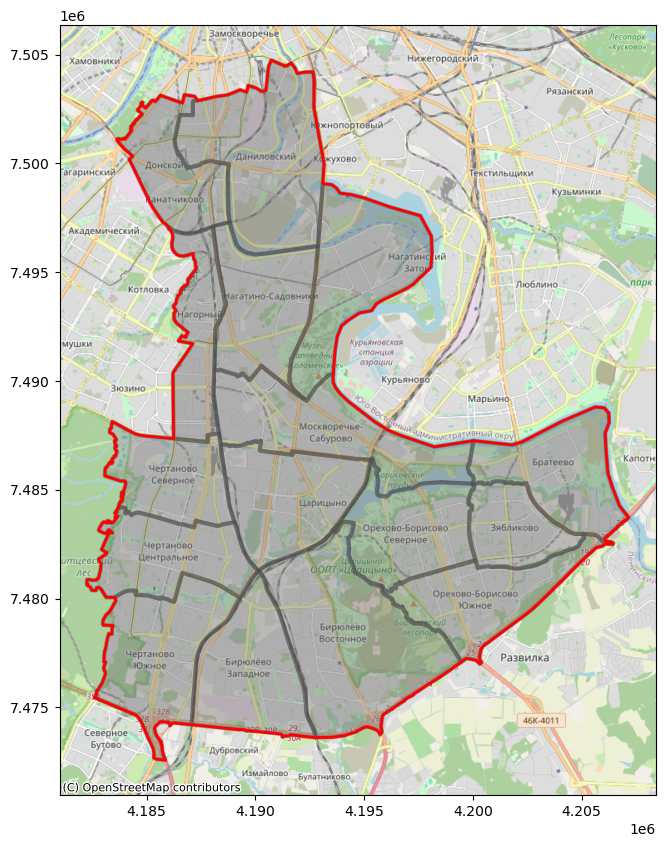

In [49]:
f, ax = plt.subplots(1, 1, figsize=(15, 10))
district_uao.to_crs("epsg:3857").plot(ax=ax, color='#696969', edgecolor="#444444", linewidth=3, alpha=0.4)
okrug.to_crs("epsg:3857").plot(ax=ax, facecolor='none', edgecolor="red", linewidth=2)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

Видим, что данные согласованы: районы ЮАО (серая заливка) находятся внутри полигона ЮАО (красный контур) и полностью покрывают его.

In [50]:
# Сохраним границы районов ЮАО в файл
district_uao.to_file("./data/processed/district_uao.geojson", driver="GeoJSON")

### 2.4 Супермаркеты Москвы

Данные о стационарных торговых объектах Москвы доступны на "Портале открытых данных Правительства Москвы" по ссылке https://data.mos.ru/opendata/3304?pageSize=10&pageIndex=0&isDynamic=false&version=1&release=226. Можно получить данные в формате geojson по 1000 строк в каждом запросе.
Поэтому напишем цикл для загрузки данных.
Будем использовать параметр bbox для получения данных только в нужной части Москвы.
Для доступа к данным необходим уникальный API-ключ, который можно получить при авторизации на сайте data.mos.ru. API-ключ сохранен в .env-файле каталога.

In [91]:
#Загрузим API-ключ для доступа к данным на data.mos.ru из env-файла
dotenv_path = "./Find locations for supermarket.env"
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path)
API_KEY = os.getenv("DATA_MOS_API_KEY")

In [92]:
url = "https://apidata.mos.ru/v1/datasets/3304/features"
params = {"api_key": API_KEY, "bbox": "37.5697983,55.5663727,37.793561,55.729465"}
response = requests.get(url, params=params)
# Создаем геодатафрейм из результатов первого запроса
if response.status_code == 200:
    shop_mos_json = response.json()
    shop_mos_gdf = gpd.GeoDataFrame.from_features(shop_mos_json["features"])
m = len(shop_mos_gdf)
n = m
#В цикле проверяем, сколько объектов было загружено на предыдущем шаге. Если ноль, то прерываем цикл, так как все данные уже загружены.
while m > 0:         
    params = {"api_key": API_KEY, "bbox": "37.5697983,55.5663727,37.793561,55.729465", "$skip": n}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        shop_mos_json = response.json()
        m = len(shop_mos_json["features"]) 
        shop_mos_curr = gpd.GeoDataFrame.from_features(shop_mos_json["features"])
        shop_mos_gdf = pd.concat([shop_mos_gdf, shop_mos_curr])
        n += m
    else:
        break

In [93]:
shop_mos_gdf.head(2)

geometry  datasetId rowId  \
0  POINT (37.62518 55.71118)       3304  None   
1   POINT (37.6602 55.71391)       3304  None   

                                          attributes  releaseNumber  \
0  {'global_id': 637392270, 'is_deleted': 0, 'ID'...            239   
1  {'global_id': 637392532, 'is_deleted': 0, 'ID'...            239   

   versionNumber  
0              1  
1              1

In [94]:
shop_mos_gdf.shape

(16312, 6)

In [95]:
#Проверим проекцию геодатафрейма
shop_mos_gdf.crs

In [96]:
#Присвоим проекцию EPSG:4326
shop_mos_gdf.set_crs("EPSG:4326", inplace=True)

geometry  datasetId rowId  \
0    POINT (37.62518 55.71118)       3304  None   
1     POINT (37.6602 55.71391)       3304  None   
2     POINT (37.6943 55.63982)       3304  None   
3    POINT (37.58252 55.61366)       3304  None   
4    POINT (37.59952 55.60483)       3304  None   
..                         ...        ...   ...   
307  POINT (37.74972 55.72686)       3304  None   
308    POINT (37.752 55.72637)       3304  None   
309  POINT (37.79229 55.71671)       3304  None   
310   POINT (37.79192 55.7173)       3304  None   
311  POINT (37.79332 55.71701)       3304  None   

                                            attributes  releaseNumber  \
0    {'global_id': 637392270, 'is_deleted': 0, 'ID'...            239   
1    {'global_id': 637392532, 'is_deleted': 0, 'ID'...            239   
2    {'global_id': 637395486, 'is_deleted': 0, 'ID'...            239   
3    {'global_id': 637396158, 'is_deleted': 0, 'ID'...            239   
4    {'global_id': 637396280, 'is_deleted': 0, 'ID'...            239   
..                                                 ...            ...   
307  {'global_id': 2795101617, 'is_deleted': 0, 'ID...            239   
308  {'global_id': 2795101624, 'is_deleted': 0, 'ID...            239   
309  {'global_id': 2795101632, 'is_deleted': 0, 'ID...            239   
310  {'global_id': 2795101638, 'is_deleted': 0, 'ID...            239   
311  {'global_id': 2795101639, 'is_deleted': 0, 'ID...            239   

     versionNumber  
0                1  
1                1  
2                1  
3                1  
4                1  
..             ...  
307              1  
308              1  
309              1  
310              1  
311              1  

[16312 rows x 6 columns]

In [97]:
# Cохраним загруженные данные по магазинам в файл
shop_mos_gdf.to_file("./data/source/shop_mos_gdf_original.geojson", driver="GeoJSON")

Как было видно выше, атрибуты магазинов хранятся в одном поле attributes. Развернем атрибуты в отдельные колонки.

In [98]:
#Создадим копию геодатафрейма с магазинами и будем работать с ней
shop_mos_gdf_temp = shop_mos_gdf.copy()

In [99]:
# Сохраним в отдельный атрибут идентификатор global_id из поля attributes. В дальнейшем он будет использоваться в качестве идентификатора магазина.
shop_mos_gdf_temp['global_id_2'] = shop_mos_gdf_temp.attributes.apply(lambda x: x['global_id'])

In [100]:
# Развернем атрибуты attributes в отдельные колонки
attributes_expanded = pd.json_normalize(shop_mos_gdf_temp["attributes"])

In [101]:
# Объединяем с исходным GeoDataFrame, удаляем старую колонку `attributes`
shop_mos_gdf_normalized = shop_mos_gdf_temp.merge(attributes_expanded, left_on="global_id_2", right_on="global_id", how="left").drop(columns=["attributes"], axis=1)

In [102]:
shop_mos_gdf_normalized.head(2)

geometry  datasetId rowId  releaseNumber  versionNumber  \
0  POINT (37.62518 55.71118)       3304  None            239              1   
1   POINT (37.6602 55.71391)       3304  None            239              1   

   global_id_2  global_id  is_deleted         ID                   Name  \
0    637392270  637392270           0  000069357       Монастырский мед   
1    637392532  637392532           0  000069364  Крепежные инструменты   

  IsNetObject OperatingCompany                             TypeService  \
0         нет                     реализация продовольственных товаров   
1         нет                   реализация непродовольственных товаров   

                       TypeObject                       AdmArea  \
0              Магазин «Продукты»  Южный административный округ   
1  Магазин «Хозяйственные товары»  Южный административный округ   

            District                                            Address  \
0  Даниловский район  Российская Федерация, город Москва, внутригоро...   
1  Даниловский район  Российская Федерация, город Москва, внутригоро...   

                                         PublicPhone  \
0  [{'is_deleted': 0, 'global_id': 252563, 'syste...   
1  [{'is_deleted': 0, 'global_id': 252566, 'syste...   

                                        WorkingHours  \
0  [{'is_deleted': 0, 'global_id': 1836211, 'DayO...   
1  [{'is_deleted': 0, 'global_id': 1836232, 'DayO...   

  ClarificationOfWorkingHours  
0                              
1

Поскольку при загрузке данных в качестве экстента мы задавали bbox, а не точные границы ЮАО, то в этом перечне имеются лишние точки магазинов, относящиеся к другим округам. Отфильтруем их с помощью атрибута AdmArea (административный округ).

In [103]:
shop_mos_gdf_normalized.AdmArea.unique()

array(['Южный административный округ',
       'Юго-Западный административный округ',
       'Юго-Восточный административный округ',
       'Центральный административный округ'], dtype=object)

In [104]:
shop_mos_gdf_filtered = shop_mos_gdf_normalized.query('`AdmArea` == "Южный административный округ"')

In [105]:
shop_mos_gdf_filtered.head(2)

geometry  datasetId rowId  releaseNumber  versionNumber  \
0  POINT (37.62518 55.71118)       3304  None            239              1   
1   POINT (37.6602 55.71391)       3304  None            239              1   

   global_id_2  global_id  is_deleted         ID                   Name  \
0    637392270  637392270           0  000069357       Монастырский мед   
1    637392532  637392532           0  000069364  Крепежные инструменты   

  IsNetObject OperatingCompany                             TypeService  \
0         нет                     реализация продовольственных товаров   
1         нет                   реализация непродовольственных товаров   

                       TypeObject                       AdmArea  \
0              Магазин «Продукты»  Южный административный округ   
1  Магазин «Хозяйственные товары»  Южный административный округ   

            District                                            Address  \
0  Даниловский район  Российская Федерация, город Москва, внутригоро...   
1  Даниловский район  Российская Федерация, город Москва, внутригоро...   

                                         PublicPhone  \
0  [{'is_deleted': 0, 'global_id': 252563, 'syste...   
1  [{'is_deleted': 0, 'global_id': 252566, 'syste...   

                                        WorkingHours  \
0  [{'is_deleted': 0, 'global_id': 1836211, 'DayO...   
1  [{'is_deleted': 0, 'global_id': 1836232, 'DayO...   

  ClarificationOfWorkingHours  
0                              
1

In [106]:
# Оставим в геодатафрейме только нужные колонки
shop_mos_gdf_filtered.columns

Index(['geometry', 'datasetId', 'rowId', 'releaseNumber', 'versionNumber',
       'global_id_2', 'global_id', 'is_deleted', 'ID', 'Name', 'IsNetObject',
       'OperatingCompany', 'TypeService', 'TypeObject', 'AdmArea', 'District',
       'Address', 'PublicPhone', 'WorkingHours',
       'ClarificationOfWorkingHours'],
      dtype='object')

В дальнейшем нам потребуются следующие атрибуты (для анализа данных и для вывода краткой информации о магазине на карте):
- 'geometry' - геометрия объектов;
- 'global_id' - уникальный идентификатор объекта;
- 'Name' - название магазина;
- 'IsNetObject' - является ли магазин сетевым;
- 'TypeObject' - тип магазина;
- 'Address' - адрес.
Оставим в датафрейме только эти атрибуты.

In [107]:
shop_mos_gdf_filtered = shop_mos_gdf_filtered[['geometry', 'global_id', 'Name', 'IsNetObject', 'TypeObject', 'Address']]

В перечне магазинов присутствуют не только супермаркеты, но и магазины непродовольственных товаров (одежды, мебели, электроники и пр.), а также узкоспециализированные продуктовые магазины (мяса, молочных продуктов, овощей и пр.) Отфильтруем магазины по типу (с помощью атрибута TypeObject), чтобы оставить только супермаркеты и подобные магазины с широким ассортиментом.

In [108]:
#Выведем уникальные значения типов магазинов
shop_mos_gdf_filtered.TypeObject.unique()

array(['Магазин «Продукты»', 'Магазин «Хозяйственные товары»',
       'Универсам',
       'Прочие специализированные продовольственные предприятия торговли',
       'Магазин-салон', 'Магазин «Цветы»',
       'Прочие специализированные непродовольственные предприятия торговли',
       'Минимаркет', 'Магазин «Обувь»', 'Магазин «Одежда»',
       'Магазин «Алкогольные напитки»', 'Магазин «Овощи-фрукты»',
       'Магазин «Ткани»', 'Магазин «Хлеб»', 'Магазин «Книги»',
       'Супермаркет', 'Магазин «Зоотовары»', 'Магазин «Мир садовода»',
       'Магазин «Электротовары»', 'Товары для дома', 'Магазин «Мясо»',
       'Товары для мужчин', 'Магазин «Спорт и туризм»',
       'Магазин «Мебель»', 'Магазин «Колбасы»', 'Товары для детей',
       'Магазин товаров повседневного спроса', 'Товары для женщин',
       'Автосалон', 'Гастроном', 'Магазин «Бутик»', 'Торговый Дом',
       'Военторг', 'Гипермаркет (продовольственный)',
       'Магазин «Промтовары»', 'Магазин «Рыба»', 'Комиссионный магазин',
    

In [109]:
# Нам подходят супермаркеты, гипермаркеты, магазины продуктов, гастрономы и универсамы. 
# Минимаркеты убираем, так как это в основном магазины на заправках с очень ограниченным ассортиментом. Более универсальные магазины обычно помечаются как супермаркет или универсам.
type_list = ["Супермаркет", "Гипермаркет (продовольственный)", "Универсам", "Магазин «Продукты»", "Гастроном"]

In [110]:
supermarket_gdf = shop_mos_gdf_filtered.query('TypeObject in @type_list')

In [111]:
supermarket_gdf.TypeObject.unique()

array(['Магазин «Продукты»', 'Универсам', 'Супермаркет', 'Гастроном',
       'Гипермаркет (продовольственный)'], dtype=object)

In [112]:
# Сохраним в файл для просмотра в QGIS
supermarket_gdf.to_file("./data/processed/supermarket.geojson", driver="GeoJSON")

In [113]:
del shop_mos_gdf_filtered, shop_mos_gdf_normalized, shop_mos_gdf_temp, shop_mos_gdf

### 2.5 Жилые дома Москвы

Файл реестра домов в виде csv был скачан вручную по ссылке https://xn--80adsazqn.xn--p1aee.xn--p1ai/opendata?gid=2280999&page=2&pageSize=12. В разделе "Структура набора" на той же странице приведено описание структуры файла.

In [114]:
# Загрузка данных в dataframe
reestr = pd.read_csv("./data/source/export-reestrmkd-77-20250701.csv", delimiter=';')

In [115]:
reestr.shape

(34704, 60)

In [116]:
reestr.columns

Index(['id', 'region_id', 'area_id', 'city_id', 'street_id',
       'shortname_region', 'formalname_region', 'shortname_area',
       'formalname_area', 'shortname_city', 'formalname_city',
       'shortname_street', 'formalname_street', 'house_number', 'building',
       'block', 'letter', 'address', 'houseguid', 'management_organization_id',
       'built_year', 'exploitation_start_year', 'project_type', 'house_type',
       'is_alarm', 'method_of_forming_overhaul_fund', 'floor_count_max',
       'floor_count_min', 'entrance_count', 'elevators_count',
       'energy_efficiency', 'quarters_count', 'living_quarters_count',
       'unliving_quarters_count', 'area_total', 'area_residential',
       'area_non_residential', 'area_common_property', 'area_land',
       'parking_square', 'playground', 'sportsground', 'other_beautification',
       'foundation_type', 'floor_type', 'wall_material', 'basement_area',
       'chute_type', 'chute_count', 'electrical_type',
       'electrical_entrie

In [117]:
# Сохраним только нужные поля, показывающие адресную информацию и жилую площадь
reestr_short = reestr[['id', 'formalname_region', 'formalname_city', 'shortname_street', 'formalname_street', 'house_number', 'building', 'block', 'letter', \
                       'address', 'area_residential']]

Содержимое колонок:

- id - ID дома на Портале;

- formalname_region - Субъект РФ (наименование);

- formalname_city - Населенный пункт (наименование);

- shortname_street - Тип улицы;

- formalname_street - Улица (наименование);

- house_number - Номер дома;

- building- Строение;

- block - Корпус;

- letter - Литера;

- address - Адрес дома;

- area_residential - Общая площадь жилых помещений, кв.м.

In [118]:
del reestr

### 2.6 Численность населения районов ЮАО

Данные Мосстата о численности населения по районам Москвы на 1 января 2025 года были скачаны в виде doc-файла со страницы https://77.rosstat.gov.ru/folder/64634?ysclid=manuswzgup941470547.

[Прямая ссылка на doc-файл](https://77.rosstat.gov.ru/storage/mediabank/%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0%20%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B3.%20%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B%20%D0%BF%D0%BE%20%D1%81%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D1%8E%20%D0%BD%D0%B0%201%20%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8F%202025%20%D0%B3%D0%BE%D0%B4%D0%B0%20%D0%B8%20%D0%B2%20%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%BC%20%D0%B7%D0%B0%202024%20%D0%B3%D0%BE%D0%B4(2).doc)

Из полученного doc-файла были вручную выбраны данные, относящиеся к районам ЮАО, и сохранены в csv-файл /data/source/uao_okrug_pop_01.01.25.csv.

In [119]:
# Загрузим данные из csv-файла в датафрейм
mo_uao_pop = pd.read_csv("./data/source/uao_okrug_pop_01.01.25.csv", header=0)

In [120]:
mo_uao_pop

Okrug  Population
0          Бирюлево Восточное      155760
1           Бирюлево Западное       84910
2                    Братеево      100282
3                 Даниловский      104718
4                     Донской       51202
5                   Зябликово      133650
6        Москворечье-Сабурово       87843
7          Нагатино-Садовники       83794
8           Нагатинский затон      121411
9                    Нагорный       76015
10  Орехово-Борисово Северное      124071
11     Орехово-Борисово Южное      146515
12                   Царицыно      117967
13         Чертаново Северное      109627
14      Чертаново Центральное      111581
15            Чертаново Южное      156178

### 2.7 Улицы ЮАО

Классификатор улиц Москвы был скачан вручную в виде csv-файла с Портала открытых данных Правительства Москвы: https://data.mos.ru/opendata/2044.

In [132]:
# Загрузим классификатор улиц из csv-файла в геодатафрейм
reestr_ulic = pd.read_csv("./data/source/street-classifier_30.05.2025.csv", delimiter=";", header=1)

In [133]:
reestr_ulic.head()

Полное наименование Сокращённое наименование   Код  \
0  1-й Ирининский переулок      1-й Ирининский пер.  8880   
1  2-й Ирининский переулок      2-й Ирининский пер.  8890   
2  3-й Ирининский переулок      3-й Ирининский пер.  8891   
3          Иркутская улица            Иркутская ул.  8910   
4     1-й Иртышский проезд        1-й Иртышский пр.  8920   

                Транслитерация  Код вида Код ОМК ТМ Код ОМК ТЕ  \
0  Pervy'j Irininskij pereulok         2        NaN       0102   
1   Vtoroj Irininskij pereulok         2        NaN       0102   
2   Tretij Irininskij pereulok         2        NaN       0102   
3            Irkutskaya ulicza         1        NaN       0406   
4   Pervy'j Irty'shskij proezd         3        NaN       0406   

           Код КЛАДР  global_id  Unnamed: 9  
0  77000000000706300   58481065         NaN  
1  77000000000362200   58481066         NaN  
2  77000000000362300   58481067         NaN  
3  77000000000139700   58481068         NaN  
4  77000000000331600   58481069         NaN

Мы хотим оставить только те улицы, которые полностью или частично расположены в ЮАО. Этот список улиц будет далее использоваться для фильтрации домов Москвы. Для этого воспользуемся фильтром по полю "Код ОМК ТЕ", показывающим принадлежность улиц к районам Москвы.

Перечень кодов районов ЮАО получим из датафрейма district_uao_classifier, подготовленного ранее (п. 2.2).

In [134]:
district_uao_classifier

Наименование  Код
77         район Бирюлёво Восточное  606
78          район Бирюлёво Западное  607
79                   район Братеево  608
80                Даниловский район  609
81                    Донской район  610
82                  район Зябликово  611
83       район Москворечье-Сабурово  612
84         район Нагатино-Садовники  613
85          район Нагатинский Затон  614
86                   Нагорный район  615
87  район Орехово-Борисово Северное  616
88     район Орехово-Борисово Южное  617
89                   район Царицыно  618
90         район Чертаново Северное  619
91      район Чертаново Центральное  620
92            район Чертаново Южное  621

Необходимо учесть, что в датафрейме district_uao_classifier коды приведены без начального символа "0". Кроме того, отдельные улицы из датафрейма reestr_ulic содержат несколько кодов районов, как показано в примере ниже.

In [135]:
reestr_ulic[reestr_ulic["Полное наименование"].str.startswith("Каширское")]

Полное наименование Сокращённое наименование   Код     Транслитерация  \
97     Каширское шоссе             Каширское ш.  9830  Kashirskoe shosse   

    Код вида Код ОМК ТМ           Код ОМК ТЕ          Код КЛАДР  global_id  \
97         6        NaN  0612;0613;0616;0617  77000000000049600   58481166   

    Unnamed: 9  
97         NaN

In [136]:
# Шаблон для поиска данных
pattern = ('|').join(district_uao_classifier["Код"].astype(str))
pattern

'606|607|608|609|610|611|612|613|614|615|616|617|618|619|620|621'

In [137]:
# Отбираем улицы, соответствующие шаблону
reestr_ulic_uao = reestr_ulic[reestr_ulic["Код ОМК ТЕ"].str.contains(pattern, case=False, na=False)]

In [138]:
reestr_ulic_uao

Полное наименование Сокращённое наименование    Код  \
18          Кавказский бульвар        Кавказский бульв.   9040   
44       Малая Калужская улица         М. Калужская ул.   9320   
45    Малый Калужский переулок        М. Калужский пер.   9330   
53       Канатчиковский проезд       Канатчиковский пр.   9415   
54        Кантемировская улица       Кантемировская ул.   9420   
...                        ...                      ...    ...   
5228  улица Эдуарда Стрельцова   ул. Эдуарда Стрельцова  50270   
5229     улица Виктора Маслова      ул. Виктора Маслова  50275   
5545   улица Маршала Батицкого    ул. Маршала Батицкого  49990   
5571            улица Аршинова             ул. Аршинова  50110   
5577        Шайдаровская улица         Шайдаровская ул.  50125   

                   Транслитерация  Код вида Код ОМК ТМ      Код ОМК ТЕ  \
18             Kavkazskij bul`var         8        NaN            0618   
44      Malaya Kaluzhskaya ulicza         1        NaN            0610   
45     Maly'j Kaluzhskij pereulok         2        NaN            0610   
53         Kanatchikovskij proezd         3        NaN            0610   
54         Kantemirovskaya ulicza         1        NaN  0612;0618;0615   
...                           ...       ...        ...             ...   
5228  ulicza E`duarda Strel`czova         1        NaN            0609   
5229       ulicza Viktora Maslova         1        NaN            0609   
5545   ulicza Marshala Baticzkogo         1        NaN            0621   
5571             ulicza Arshinova         1        NaN            0618   
5577        Shajdarovskaya ulicza         1        NaN            0612   

              Код КЛАДР   global_id  Unnamed: 9  
18    77000000000049100    58481083         NaN  
44    77000000000142200    58481110         NaN  
45    77000000000364800    58481111         NaN  
53    77000000000365000    58481120         NaN  
54    77000000000049200    58481121         NaN  
...                 ...         ...         ...  
5228  77000000000014300  2782291953         NaN  
5229  77000000000014200  2782291954         NaN  
5545  77000000000011800  2782292270         NaN  
5571  77000000000013000  2782292296         NaN  
5577  77000000000013300  2782292302         NaN  

[347 rows x 10 columns]

In [139]:
# Оставим только нужные колонки
reestr_ulic_uao = reestr_ulic_uao[["Полное наименование", "Сокращённое наименование", "Код ОМК ТЕ"]]

In [140]:
# Сохраним реестр улиц ЮАО в файл
reestr_ulic_uao.to_csv("./data/processed/reestr_ulic_uao.csv", sep=";")

In [141]:
del reestr_ulic

### 2.8 Строения ЮАО

Строения в ЮАО (и жилые, и нежилые) нам потребуются в дальнейшем для отбора потенциальных мест под новый магазин - чтобы исключить гексагоны, в которых отсутствуют какие-либо строения и, соответственно, нет возможности открыть магазин без строительства нового здания.

Скачаем строения с сервиса OpenStreetMap с помощью библиотеки osmnx (импортирована как ox).

In [508]:
# Нас интересуют все здания
tags = {'building': True}

In [509]:
buildings_uao_all = ox.features_from_polygon(okrug_polygon, tags)

In [510]:
buildings_uao_all.shape

(16369, 339)

In [511]:
buildings_uao_all.head(2)

geometry    amenity building  \
element id                                                          
node    811348872   POINT (37.65555 55.68205)  ice_cream    kiosk   
        1112950360  POINT (37.70905 55.60912)        NaN    kiosk   

                   building:levels inscription    name       shop  \
element id                                                          
node    811348872                1   Мороженое     NaN        NaN   
        1112950360               1      Пресса  Пресса  newsagent   

                   addr:housenumber addr:street military  ... building:parts  \
element id                                                ...                  
node    811348872               NaN         NaN      NaN  ...            NaN   
        1112950360              NaN         NaN      NaN  ...            NaN   

                   building:condition castle_type museum trade leaf_type  \
element id                                                                 
node    811348872                 NaN         NaN    NaN   NaN       NaN   
        1112950360                NaN         NaN    NaN   NaN       NaN   

                   plant:source aeroway:light aeroway:light:character  \
element id                                                              
node    811348872           NaN           NaN                     NaN   
        1112950360          NaN           NaN                     NaN   

                   aeroway:light:colour  
element id                               
node    811348872                   NaN  
        1112950360                  NaN  

[2 rows x 339 columns]

In [512]:
buildings_uao_all.reset_index(inplace=True)

In [513]:
buildings_uao_all.head(2)

element          id                   geometry    amenity building  \
0    node   811348872  POINT (37.65555 55.68205)  ice_cream    kiosk   
1    node  1112950360  POINT (37.70905 55.60912)        NaN    kiosk   

  building:levels inscription    name       shop addr:housenumber  ...  \
0               1   Мороженое     NaN        NaN              NaN  ...   
1               1      Пресса  Пресса  newsagent              NaN  ...   

  building:parts building:condition castle_type museum trade leaf_type  \
0            NaN                NaN         NaN    NaN   NaN       NaN   
1            NaN                NaN         NaN    NaN   NaN       NaN   

  plant:source aeroway:light aeroway:light:character aeroway:light:colour  
0          NaN           NaN                     NaN                  NaN  
1          NaN           NaN                     NaN                  NaN  

[2 rows x 341 columns]

In [514]:
# Оставим только нужные колонки (фактически, дальше мы будем использовать только геометрию объектов и идентификаторы)
buildings_uao_all = buildings_uao_all[["id", "geometry"]]

In [515]:
# Сохраним строения в файл
buildings_uao_all.to_file("./data/processed/buildings_uao_all.geojson", driver="GeoJSON")

### 2.9 Парки ЮАО

Парки ЮАО нам потребуются в дальнейшем для отбора потенциальных мест под новый магазин - чтобы исключить гексагоны, которые расположены в парках и, соответственно, нет возможности открыть там новый супермаркет.

Скачаем парки с сервиса OpenStreetMap с помощью библиотеки osmnx (импортирована как ox).

In [526]:
# Скачаем из OSM полигоны с тегом leisure=park.
tags = {'leisure': 'park'}
parks = ox.features_from_polygon(okrug_polygon, tags)

In [527]:
parks.reset_index(inplace=True)

In [528]:
parks.head(2)

element       id                                           geometry  \
0  relation  1380224  MULTIPOLYGON (((37.59156 55.60627, 37.59299 55...   
1  relation  1480094  POLYGON ((37.73577 55.61172, 37.73731 55.61183...   

  description leisure                                name access barrier  \
0         NaN    park   Парк Каскад Кировоградских прудов    NaN     NaN   
1         NaN    park  Шмелёвский овраг до улицы Ясеневой    NaN     NaN   

  fence_type landuse  ... subject:wikidata contact:email contact:fax  \
0        NaN     NaN  ...              NaN           NaN         NaN   
1        NaN     NaN  ...              NaN           NaN         NaN   

  contact:phone contact:website name:de leaf_cycle leaf_type fixme  \
0           NaN             NaN     NaN        NaN       NaN   NaN   
1           NaN             NaN     NaN        NaN       NaN   NaN   

  operator:type  
0           NaN  
1           NaN  

[2 rows x 59 columns]

In [529]:
# Оставим только нужные колонки (фактически, дальше мы будем использовать только геометрию объектов)
parks = parks[["id", "geometry"]]

In [530]:
# На всякий случай выполним сборку мусора для освобождения памяти
gc.collect()

286

## 3 Подготовка данных

Основным этапом подготовки данных является геокодирование реестра жилых домов. После того, как дома будут позиционированы на карте, их жилая площадь будет использоваться для оценки численности жителей домов.

### 3.1 Геокодирование адресов

Геокодирование будем проводить в браузере с помощью Awesome Table - инструмента для Google Sheets. Поскольку при использовании бесплатной версии имеются ограничения на количество запросов к геокодеру, то необходимо предварительно сократить количество адресов, которые потребуется геокодировать. В настоящее время адресов жилых домов более 30 тысяч.

Шаги:
1. Из списка домов отберем только те, улицы которых входят в перечень улиц ЮАО;
2. Геокодируем адреса;
3. Оставим только те точки зданий, которые попадают в границы ЮАО.

In [155]:
reestr_short.shape

(34704, 11)

#### 3.1.1 Фильтрация домов по названиям улиц

Отфильтруем дома из датафрейма reestr_short по названиям улиц (поле formalname_street): отберем только те дома, у которых наименования улиц попадают в реестр улиц ЮАО (перечень улиц ЮАО был получен в предыдущем пункте и содержится в датафрейме reestr_ulic_uao).

При этом мы потеряем некоторое количество домов, у которых поле formalname_street пустое. Посмотрим, что это за дома.

In [157]:
reestr_short.query("formalname_street.isnull()")

id formalname_region formalname_city shortname_street  \
0      8649748            Москва             NaN              NaN   
1      9370109            Москва             NaN              NaN   
2      9388585            Москва             NaN              NaN   
3      8963246            Москва             NaN              NaN   
4      9388617            Москва             NaN              NaN   
...        ...               ...             ...              ...   
33400  8197432            Москва          Щапово              NaN   
33401  8919514            Москва          Щапово              NaN   
33402  9092432            Москва          Щапово              NaN   
33403  9092435            Москва          Щапово              NaN   
33835  9376264            Москва             NaN              NaN   

      formalname_street        house_number building block letter  \
0                   NaN                   9      NaN     1    NaN   
1                   NaN                  14      NaN     1    NaN   
2                   NaN                  42      NaN   NaN    NaN   
3                   NaN                  42      NaN     2    NaN   
4                   NaN                  44      NaN   NaN    NaN   
...                 ...                 ...      ...   ...    ...   
33400               NaN                  56      NaN   NaN    NaN   
33401               NaN                  57      NaN   NaN    NaN   
33402               NaN                  58      NaN   NaN    NaN   
33403               NaN                  59      NaN   NaN    NaN   
33835               NaN  Эльдара Рязанова 2      NaN   NaN    NaN   

                                         address area_residential  
0                          г. Москва, д. 9, к. 1          4940,00  
1                         г. Москва, д. 14, к. 1              NaN  
2                               г. Москва, д. 42              NaN  
3                         г. Москва, д. 42, к. 2         25943,00  
4                               г. Москва, д. 44              NaN  
...                                          ...              ...  
33400  г. Москва, п. Щаповское, п. Щапово, д. 56          7935,60  
33401  г. Москва, п. Щаповское, п. Щапово, д. 57          6173,40  
33402  г. Москва, п. Щаповское, п. Щапово, д. 58          6966,80  
33403  г. Москва, п. Щаповское, п. Щапово, д. 59          8527,10  
33835           г. Москва, д. Эльдара Рязанова 2              NaN  

[1135 rows x 11 columns]

Большинство домов из этого перечня расположены в отдельных населенных пунктах в составе Москвы: Зеленоград, Коммунарка и др. К ЮАО эти населенные пункты не относятся, поэтому такие дома мы можем не рассматривать.

In [82]:
reestr_short.query("formalname_street.isnull()").formalname_city.value_counts()

formalname_city
Зеленоград                     526
Коммунарка                      64
Ватутинки                       51
завода Мосрентген               48
Воскресенское                   47
Щапово                          37
Знамя Октября                   32
Остафьево                       29
Фабрики им 1 Мая                29
Пыхтино                         24
Шишкин Лес                      23
Марьино                         19
Газопровод                      18
Красная Пахра                   14
Акулово                         12
Жуковка                         12
Ерино                           11
Малино                          11
д/о Вороново                     9
Загорье                          7
Секерино                         7
Ильичевка                        7
Ватутинки-1                      6
Филимонки                        6
Института Полиомиелита           6
Спортбазы                        5
Армейский                        5
Московский                       5
Валу

Кроме того, есть небольшое количество домов (11), у которых не указаны ни название улицы, ни название населенного пункта помимо Москвы. Вероятно, это ошибочные данные, и их мы тоже рассматривать не будем.

In [83]:
reestr_short.query("formalname_street.isnull() & formalname_city.isnull()")

id formalname_region formalname_city shortname_street  \
0      8649748            Москва             NaN              NaN   
1      9370109            Москва             NaN              NaN   
2      9388585            Москва             NaN              NaN   
3      8963246            Москва             NaN              NaN   
4      9388617            Москва             NaN              NaN   
5      9388620            Москва             NaN              NaN   
6      8932138            Москва             NaN              NaN   
7      8932139            Москва             NaN              NaN   
8      8932140            Москва             NaN              NaN   
9      8932141            Москва             NaN              NaN   
33835  9376264            Москва             NaN              NaN   

      formalname_street        house_number building block letter  \
0                   NaN                   9      NaN     1    NaN   
1                   NaN                  14      NaN     1    NaN   
2                   NaN                  42      NaN   NaN    NaN   
3                   NaN                  42      NaN     2    NaN   
4                   NaN                  44      NaN   NaN    NaN   
5                   NaN                  46      NaN   NaN    NaN   
6                   NaN                2301      NaN   NaN    NaN   
7                   NaN                2302      NaN   NaN    NaN   
8                   NaN                2303      NaN   NaN    NaN   
9                   NaN                2304      NaN   NaN    NaN   
33835               NaN  Эльдара Рязанова 2      NaN   NaN    NaN   

                                address area_residential  
0                 г. Москва, д. 9, к. 1          4940,00  
1                г. Москва, д. 14, к. 1              NaN  
2                      г. Москва, д. 42              NaN  
3                г. Москва, д. 42, к. 2         25943,00  
4                      г. Москва, д. 44              NaN  
5                      г. Москва, д. 46              NaN  
6                    г. Москва, д. 2301              NaN  
7                    г. Москва, д. 2302              NaN  
8                    г. Москва, д. 2303              NaN  
9                    г. Москва, д. 2304              NaN  
33835  г. Москва, д. Эльдара Рязанова 2              NaN

In [158]:
# Удалим из реестра дома, у которых не указано название улицы
reestr_short_filtered = reestr_short[reestr_short["formalname_street"].notna()]

Теперь соберем шаблон для поиска улиц, относящихся в ЮАО. Будем использовать поле "Сокращенное наименование" датафрейма reestr_ulic_uao, предварительно удалив сокращения типа "бульв.", "ул.", "нижн.", "верх.". Также удалим номера улиц (например, "Проектируемый проезд № 1102". При удалении сокращений и номеров улиц мы можем получить "лишние" улицы, не относящиеся к ЮАО (так как не сможем отличить, например, улицы "Большая Якиманка" и "Малая Якиманка"). Но это не так важно, так как цель данного шага - просто сократить количество исходных данных перед геокодированием, не потеряв нужные данные. "Лишние" дома, не относящиеся к ЮАО, будут в дальнейшем отфильтрованы с помощью пространственного запроса по границам ЮАО.

In [674]:
reestr_ulic_uao

Полное наименование Сокращённое наименование      Код ОМК ТЕ  \
18          Кавказский бульвар        Кавказский бульв.            0618   
44       Малая Калужская улица         М. Калужская ул.            0610   
45    Малый Калужский переулок        М. Калужский пер.            0610   
53       Канатчиковский проезд       Канатчиковский пр.            0610   
54        Кантемировская улица       Кантемировская ул.  0612;0618;0615   
...                        ...                      ...             ...   
5228  улица Эдуарда Стрельцова   ул. Эдуарда Стрельцова            0609   
5229     улица Виктора Маслова      ул. Виктора Маслова            0609   
5545   улица Маршала Батицкого    ул. Маршала Батицкого            0621   
5571            улица Аршинова             ул. Аршинова            0618   
5577        Шайдаровская улица         Шайдаровская ул.            0612   

                     key  
18            Кавказский  
44             Калужская  
45             Калужский  
53        Канатчиковский  
54        Кантемировская  
...                  ...  
5228  Эдуарда Стрельцова  
5229     Виктора Маслова  
5545   Маршала Батицкого  
5571            Аршинова  
5577        Шайдаровская  

[347 rows x 4 columns]

In [675]:
words_to_remove = ["м.", "б.", "ул.", "б-р", "пр.", "ш.", "пр-кт", "пл.", "пер.", "наб.", "туп.", "бульв.", "просп.","верх.", "нижн."]

In [161]:
pattern = "|".join(map(re.escape, words_to_remove))
pattern

'м\\.|б\\.|ул\\.|б\\-р|пр\\.|ш\\.|пр\\-кт|пл\\.|пер\\.|наб\\.|туп\\.|бульв\\.|просп\\.|верх\\.|нижн\\.'

In [162]:
# Добавим к шаблону номера улиц типа "1-й", "2-я"
pattern += "|\\d+\\-[й,я]"

In [163]:
pattern

'м\\.|б\\.|ул\\.|б\\-р|пр\\.|ш\\.|пр\\-кт|пл\\.|пер\\.|наб\\.|туп\\.|бульв\\.|просп\\.|верх\\.|нижн\\.|\\d+\\-[й,я]'

In [166]:
# Названия улиц после удаления данного перечня слов сохраним в поле "key"
reestr_ulic_uao.loc[:, "key"] = reestr_ulic_uao["Сокращённое наименование"].str.replace(pattern, "", case=False, regex=True).str.strip()

In [167]:
sorted(reestr_ulic_uao["key"].tolist())

['Автозаводская',
 'Автозаводская',
 'Автозаводский',
 'Автозаводский',
 'Автозаводский',
 'Автозаводский мост',
 'Академика Вишневского',
 'Академика Ласкорина',
 'Академика Миллионщикова',
 'Академика Петровского',
 'Академика Янгеля',
 'Александра Богомазова',
 'Алма-Атинская',
 'Андропова',
 'Арбатецкая',
 'Артековская',
 'Архитектора Гинзбурга',
 'Архитектора Голосова',
 'Архитектора Леонидова',
 'Архитектора Мельникова',
 'Архитектора Щусева',
 'Аршинова',
 'Баженова',
 'Бакинская',
 'Балаклавский',
 'Бесединский мост',
 'Бесединское',
 'Бехтерева',
 'Бирюлёвская',
 'Битцевский',
 'Бойчука',
 'Болотниковская',
 'Большая',
 'Борисовские Пруды',
 'Борисовский',
 'Борисовский мост',
 'Борисовский мост',
 'Братеевская',
 'Братеевская Слободка',
 'Братьев Весниных',
 'Братьев Рябушинских',
 'Булатниковская',
 'Булатниковский',
 'Бутовская',
 'Вавилова',
 'Валерия Харламова',
 'Варвары Степановой',
 'Варшавский',
 'Варшавский',
 'Варшавское',
 'Велозаводская',
 'Весёлая',
 'Виктора Мас

In [168]:
len(reestr_ulic_uao["key"])

347

In [169]:
# Преобразуем в множество, чтобы избавиться от одинаковых названий (они образовались из-за удаления слов из шаблона)
reestr_ulic_uao_set = set(reestr_ulic_uao["key"].tolist())
sorted(reestr_ulic_uao_set)

['Автозаводская',
 'Автозаводский',
 'Автозаводский мост',
 'Академика Вишневского',
 'Академика Ласкорина',
 'Академика Миллионщикова',
 'Академика Петровского',
 'Академика Янгеля',
 'Александра Богомазова',
 'Алма-Атинская',
 'Андропова',
 'Арбатецкая',
 'Артековская',
 'Архитектора Гинзбурга',
 'Архитектора Голосова',
 'Архитектора Леонидова',
 'Архитектора Мельникова',
 'Архитектора Щусева',
 'Аршинова',
 'Баженова',
 'Бакинская',
 'Балаклавский',
 'Бесединский мост',
 'Бесединское',
 'Бехтерева',
 'Бирюлёвская',
 'Битцевский',
 'Бойчука',
 'Болотниковская',
 'Большая',
 'Борисовские Пруды',
 'Борисовский',
 'Борисовский мост',
 'Братеевская',
 'Братеевская Слободка',
 'Братьев Весниных',
 'Братьев Рябушинских',
 'Булатниковская',
 'Булатниковский',
 'Бутовская',
 'Вавилова',
 'Валерия Харламова',
 'Варвары Степановой',
 'Варшавский',
 'Варшавское',
 'Велозаводская',
 'Весёлая',
 'Виктора Маслова',
 'Воздушная',
 'Воронежская',
 'Восточная',
 'Восточный',
 'Востряковский',
 'Высок

In [170]:
len(reestr_ulic_uao_set)

276

In [171]:
# Соберем шаблон для поиска из названий улиц ЮАО
pattern = '|'.join(map(re.escape, reestr_ulic_uao_set))
pattern

'Кожуховский|Макеевская|Новоспасский\\ мост|Академика\\ Янгеля|Кожуховская|Колобашкина|Старокаширское|Павла\\ Филонова|Прохладная|Севанская|Павелецкая|Нагатинский|Ларионова|Борисовский\\ мост|Лобанова|Луганская|Красного\\ Маяка|Михневская|Самаринская|Деловая|Архитектора\\ Щусева|Лентулова|Братеевская|Днепропетровский|Щипковский|Михайловский\\ Поперечный|Автозаводский|Канатчиковский|Ремесленная|Архитектора\\ Голосова|Борисовский|Сумская|Лебедянская|Котляковский|Академика\\ Ласкорина|Генерала\\ Белова|Лисичанская|Красный\\ Луг|Коллективный|Якорная|Маршала\\ Батицкого|Бесединское|Крестовниковых|Ленинская\\ Слобода|Бойчука|Садовая\\ Слобода|Мелитопольская|Мытная|Ильи\\ Чашника|Академика\\ Петровского|Нагорный|Медынская|Битцевский|Павла\\ Андреева|Харьковский|Воронежская|Жуков|Марка\\ Шагала|Коломенское|Калужский|Ленинский|Новоданиловская|Симоновский\\ Вал|км\\ МКАД|Булатниковская|Корабельная|Кленовый|Михневский|Братеевская\\ Слободка|Симферопольский|Рощинский|Элеваторная|Академика\\ Миллио

In [172]:
# Отфильтруем реестр домов по названиям улиц ЮАО, используя подготовленный шаблон
reestr_short_uao = reestr_short_filtered[reestr_short_filtered["formalname_street"].str.contains(pattern, case=False, regex=True)]

In [173]:
reestr_short_uao.shape

(4479, 11)

Мы сократили количество строений для геокодирования - 4479 вместо 34703.

In [174]:
# Сохраним отфильтрованный перечень домов в csv-файл
reestr_short_uao.to_csv("./data/processed/buildings_uao.csv", sep=";")

In [175]:
del reestr_short, reestr_short_filtered, reestr_ulic_uao_set

#### 3.1.2 Геокодирование адресов

Далее было проведено геокодирование адресов с помощью Awesome Table - инструмента для Google Sheets. Результаты были сохранены в csv-файл. Загрузим получившиеся точки в датафрейм.

In [676]:
buildings_uao_geocoded = pd.read_csv("./data/processed/buildings_uao_geocoded.csv")

In [677]:
buildings_uao_geocoded.head(2)

Unnamed: 0       id formalname_region formalname_city shortname_street  \
0         396  7606363            Москва             NaN               ул   
1         397  7606365            Москва             NaN               ул   

  formalname_street house_number building block letter  \
0     Автозаводская            2      NaN   NaN    NaN   
1     Автозаводская            3      NaN   NaN    NaN   

                              address   Latitude  Longitude area_residential  
0  г. Москва, ул. Автозаводская, д. 2  55.704409  37.634574          6550,60  
1  г. Москва, ул. Автозаводская, д. 3  55.704102  37.634219          9340,90

Как видно из структуры данных, были добавлены колонки Latitude и Longitude, из которых можно создать точечный объект shapely и преобразовать датафрейм в геодатафрейм.

In [678]:
# Создадим поле геометрии с точечными объектами shapely
buildings_uao_geocoded['geometry'] = buildings_uao_geocoded.apply(lambda x: Point([x.Longitude, x.Latitude]), axis=1)

In [679]:
# Преобразуем датафрейм в геодатафрейм
buildings_uao_gdf = gpd.GeoDataFrame(buildings_uao_geocoded, geometry='geometry', crs="EPSG:4326")

In [183]:
del buildings_uao_geocoded

#### 3.1.3 Отбор точек внутри границ ЮАО

In [680]:
# Оставим только те геокодированные точки, которые попадают внутрь границ ЮАО
buildings_uao_clipped = buildings_uao_gdf[buildings_uao_gdf.within(okrug_polygon)]

In [681]:
buildings_uao_clipped.shape

(2843, 15)

In [682]:
# Сохраним получившиеся данные в файл
buildings_uao_clipped.to_file("./data/processed/buildings_uao_clipped.geojson", driver="GeoJSON")

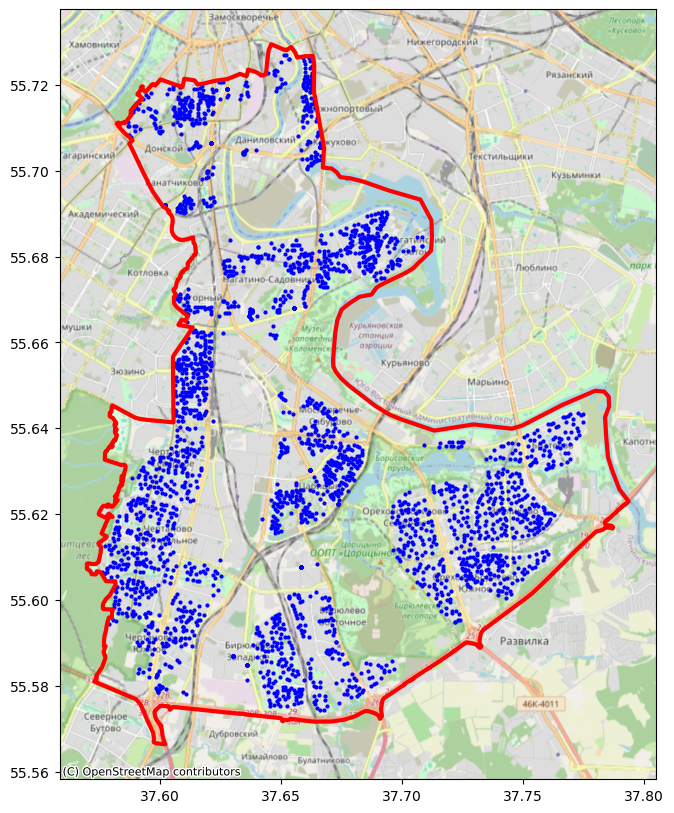

In [683]:
f, ax = plt.subplots(1, 1, figsize=(15, 10))
buildings_uao_clipped.plot(ax=ax, color="blue", markersize=4)
okrug.plot(ax=ax, facecolor='none', edgecolor="red", linewidth=3)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:4326")

In [188]:
del buildings_uao_gdf

#### 3.1.4 Проблемы с качеством данных

При изучении результатов геокодирования был выявлен ряд проблем с качеством полученных данных
1. При геокодировании некоторые точки попали на соседние дома. Например, точка дома Елецкая 10к1 оказалась на  дома Елецкая 8к1 (то есть там две точки на одном доме).
2. В новых ЖК нет информации об адресах, поэтому точки нескольких домов попали в середину одной улицы. Например, ЖК "Царицыно": точки с адресами 6-я Радиальная улица дом 3 к1-11 (не все); дом 5 к1-4 попали в одну точку - середину 6-ой Радиальной улицы.
3. Некоторые точки некорректно определены в центре Москвы - например, отдельные точки Каширского шоссе или Верхнего Михайловского проезда.

В связи с этим на будущее для территории Москвы целесообразно использовать другие сервисы геокодирования либо вручную исправить ошибки геокодирования.

In [189]:
gc.collect()

3350

## 4 Анализ данных

Анализ данных будет включать в себя следующие этапы:

1. Расчет количества жителей домов ЮАО;
2. Оценка обеспеченности жителей супермаркетами по гексагонам ЮАО;
3. Оценка обеспеченности жителей супермаркетами по районам ЮАО;
4. Поиск перспективных локаций для открытия нового супермаркета.

## 4.1 Расчет количества жителей домов ЮАО

На данном этапе рассчитаем примерную численность каждого дома исходя из жилой площади этого дома и общей численности жителей муниципального образования.

Шаги:
1. Объединить данные о численности жителей районов с границами районов;
2. Для каждого района отобрать дома, попадающие внутрь этого района, и вычислить суммарную жилую площадь отобранных домов;
3. Рассчитать оценочное количество жителей каждого дома как произведение численности жителей района на долю жилой площади этого дома от общей жилой площади в районе.

#### 4.1.1 Объединение данных о численности жителей с границами районов ЮАО

In [191]:
# Численность жителей районов ЮАО содержится в датафрейме mo_uao_pop
mo_uao_pop

Okrug  Population
0          Бирюлево Восточное      155760
1           Бирюлево Западное       84910
2                    Братеево      100282
3                 Даниловский      104718
4                     Донской       51202
5                   Зябликово      133650
6        Москворечье-Сабурово       87843
7          Нагатино-Садовники       83794
8           Нагатинский затон      121411
9                    Нагорный       76015
10  Орехово-Борисово Северное      124071
11     Орехово-Борисово Южное      146515
12                   Царицыно      117967
13         Чертаново Северное      109627
14      Чертаново Центральное      111581
15            Чертаново Южное      156178

In [192]:
# Геометрия районов содержится в датафрейме district_uao
district_uao

geometry  \
id                                                           
444908   POLYGON ((37.58214 55.71099, 37.58227 55.71103...   
455460   POLYGON ((37.65944 55.65064, 37.65849 55.65112...   
455528   POLYGON ((37.62246 55.65753, 37.62423 55.65723...   
455539   POLYGON ((37.67139 55.61998, 37.67129 55.62003...   
456807   POLYGON ((37.69141 55.60691, 37.69189 55.60699...   
531264   POLYGON ((37.72739 55.62709, 37.7274 55.6271, ...   
531287   POLYGON ((37.72712 55.6353, 37.72717 55.6353, ...   
535655   POLYGON ((37.62186 55.69073, 37.62236 55.69083...   
535662   POLYGON ((37.60374 55.69052, 37.60437 55.69028...   
535680   POLYGON ((37.57757 55.63445, 37.57778 55.6347,...   
950639   POLYGON ((37.64072 55.6105, 37.64095 55.61063,...   
950641   POLYGON ((37.62507 55.63998, 37.62587 55.64003...   
950658   POLYGON ((37.61313 55.57463, 37.61456 55.58613...   
950664   POLYGON ((37.57368 55.58221, 37.57561 55.58391...   
951305   POLYGON ((37.57002 55.6072, 37.5699 55.60724, ...   
1281209  POLYGON ((37.60616 55.71067, 37.60614 55.71082...   

                                    name  
id                                        
444908                     Донской район  
455460           район Нагатинский Затон  
455528        район Москворечье-Сабурово  
455539   район Орехово-Борисово Северное  
456807            Орехово-Борисово Южное  
531264                   район Зябликово  
531287                    район Братеево  
535655          район Нагатино-Садовники  
535662                    Нагорный район  
535680          район Чертаново Северное  
950639          район Бирюлёво Восточное  
950641                    район Царицыно  
950658           район Бирюлёво Западное  
950664             район Чертаново Южное  
951305       район Чертаново Центральное  
1281209                Даниловский район

Поскольку названия районов не полностью совпадают в таблицах mo_uao_pop и district_uao, то создадим новый ключ в таблице district_uao путем следующих преобразований в названиях:
- Удалим из названий слово "район";
- Заменим ё на е;
- Заменим "Затон" на "затон"

In [193]:
replace_dict = {"район": "", "ё":"е", "Затон": "затон"}
district_uao.loc[:, "short_name"] = district_uao["name"].replace(replace_dict, regex=True).str.strip()

In [194]:
district_uao.head()

geometry  \
id                                                          
444908  POLYGON ((37.58214 55.71099, 37.58227 55.71103...   
455460  POLYGON ((37.65944 55.65064, 37.65849 55.65112...   
455528  POLYGON ((37.62246 55.65753, 37.62423 55.65723...   
455539  POLYGON ((37.67139 55.61998, 37.67129 55.62003...   
456807  POLYGON ((37.69141 55.60691, 37.69189 55.60699...   

                                   name                 short_name  
id                                                                  
444908                    Донской район                    Донской  
455460          район Нагатинский Затон          Нагатинский затон  
455528       район Москворечье-Сабурово       Москворечье-Сабурово  
455539  район Орехово-Борисово Северное  Орехово-Борисово Северное  
456807           Орехово-Борисово Южное     Орехово-Борисово Южное

In [195]:
# Соединим датафреймы mo_uao_pop и district_uao по коротким названиям районов
district_pop = district_uao.merge(mo_uao_pop, how="left", left_on="short_name", right_on="Okrug")

In [196]:
# Удалим дублирующийся ключ
district_pop.drop(columns="short_name", inplace=True)

In [197]:
district_pop

geometry  \
0   POLYGON ((37.58214 55.71099, 37.58227 55.71103...   
1   POLYGON ((37.65944 55.65064, 37.65849 55.65112...   
2   POLYGON ((37.62246 55.65753, 37.62423 55.65723...   
3   POLYGON ((37.67139 55.61998, 37.67129 55.62003...   
4   POLYGON ((37.69141 55.60691, 37.69189 55.60699...   
5   POLYGON ((37.72739 55.62709, 37.7274 55.6271, ...   
6   POLYGON ((37.72712 55.6353, 37.72717 55.6353, ...   
7   POLYGON ((37.62186 55.69073, 37.62236 55.69083...   
8   POLYGON ((37.60374 55.69052, 37.60437 55.69028...   
9   POLYGON ((37.57757 55.63445, 37.57778 55.6347,...   
10  POLYGON ((37.64072 55.6105, 37.64095 55.61063,...   
11  POLYGON ((37.62507 55.63998, 37.62587 55.64003...   
12  POLYGON ((37.61313 55.57463, 37.61456 55.58613...   
13  POLYGON ((37.57368 55.58221, 37.57561 55.58391...   
14  POLYGON ((37.57002 55.6072, 37.5699 55.60724, ...   
15  POLYGON ((37.60616 55.71067, 37.60614 55.71082...   

                               name                      Okrug  Population  
0                     Донской район                    Донской       51202  
1           район Нагатинский Затон          Нагатинский затон      121411  
2        район Москворечье-Сабурово       Москворечье-Сабурово       87843  
3   район Орехово-Борисово Северное  Орехово-Борисово Северное      124071  
4            Орехово-Борисово Южное     Орехово-Борисово Южное      146515  
5                   район Зябликово                  Зябликово      133650  
6                    район Братеево                   Братеево      100282  
7          район Нагатино-Садовники         Нагатино-Садовники       83794  
8                    Нагорный район                   Нагорный       76015  
9          район Чертаново Северное         Чертаново Северное      109627  
10         район Бирюлёво Восточное         Бирюлево Восточное      155760  
11                   район Царицыно                   Царицыно      117967  
12          район Бирюлёво Западное          Бирюлево Западное       84910  
13            район Чертаново Южное            Чертаново Южное      156178  
14      район Чертаново Центральное      Чертаново Центральное      111581  
15                Даниловский район                Даниловский      104718

#### 4.1.2 Расчет суммарной жилой площади по районам

In [198]:
# Проверим тип поля с жилой площадью в реестре домов
buildings_uao_clipped["area_residential"].dtype

dtype('O')

Поле имеет тип object, необходимо перевести его в числовое.

In [199]:
buildings_uao_clipped["area_residential"] = pd.to_numeric(buildings_uao_clipped["area_residential"].str.replace(",", "."))

In [200]:
buildings_uao_clipped.area_residential.head(3)

0    6550.6
1    9340.9
2    6671.8
Name: area_residential, dtype: float64

In [201]:
# Выполним пространственное соединение геодатафреймов buildings_uao_pop и district_pop (условие: точка дома из buildings_uao_pop лежит внутри полигона района из district_pop). 
# При этом к геодатафрейму домов будут добавлены колонки с названием и численностью населения соответствующего района
buildings_uao_pop = gpd.sjoin(buildings_uao_clipped, district_pop, how="left", predicate="within")

In [203]:
buildings_uao_pop.head(3)

Unnamed: 0       id formalname_region formalname_city shortname_street  \
0         396  7606363            Москва             NaN               ул   
1         397  7606365            Москва             NaN               ул   
2         398  7606372            Москва             NaN               ул   

  formalname_street house_number building block letter  ...   Latitude  \
0     Автозаводская            2      NaN   NaN    NaN  ...  55.704409   
1     Автозаводская            3      NaN   NaN    NaN  ...  55.704102   
2     Автозаводская            4      NaN   NaN    NaN  ...  55.704401   

   Longitude  living_quarters_count  area_total area_residential  \
0  37.634574                   94.0     8201,80           6550.6   
1  37.634219                  143.0    11599,40           9340.9   
2  37.634641                  108.0     8391,40           6671.8   

                    geometry index_right               name        Okrug  \
0  POINT (37.63457 55.70441)          15  Даниловский район  Даниловский   
1   POINT (37.63422 55.7041)          15  Даниловский район  Даниловский   
2   POINT (37.63464 55.7044)          15  Даниловский район  Даниловский   

  Population  
0     104718  
1     104718  
2     104718  

[3 rows x 21 columns]

In [204]:
# Переименуем колонку population, чтобы было понятно, что речь идет о населении всего района, а не отдельного дома
buildings_uao_pop.rename(columns={"Population": "district_pop", "index_right": "index_district"}, inplace=True)

In [205]:
# К геодатафрейму домов добавляем колонку с суммарной жилой площадью соответствующего района
buildings_uao_pop["district_area_resid"] = buildings_uao_pop.groupby("Okrug")['area_residential'].transform('sum')

In [207]:
buildings_uao_pop.head(3)

Unnamed: 0       id formalname_region formalname_city shortname_street  \
0         396  7606363            Москва             NaN               ул   
1         397  7606365            Москва             NaN               ул   
2         398  7606372            Москва             NaN               ул   

  formalname_street house_number building block letter  ...  Longitude  \
0     Автозаводская            2      NaN   NaN    NaN  ...  37.634574   
1     Автозаводская            3      NaN   NaN    NaN  ...  37.634219   
2     Автозаводская            4      NaN   NaN    NaN  ...  37.634641   

   living_quarters_count  area_total  area_residential  \
0                   94.0     8201,80            6550.6   
1                  143.0    11599,40            9340.9   
2                  108.0     8391,40            6671.8   

                    geometry  index_district               name        Okrug  \
0  POINT (37.63457 55.70441)              15  Даниловский район  Даниловский   
1   POINT (37.63422 55.7041)              15  Даниловский район  Даниловский   
2   POINT (37.63464 55.7044)              15  Даниловский район  Даниловский   

  district_pop district_area_resid  
0       104718          1596763.11  
1       104718          1596763.11  
2       104718          1596763.11  

[3 rows x 22 columns]

In [208]:
# Рассчитаем численность жителей домов, распределив общую численность района по домам пропорционально жилой площади домов
buildings_uao_pop["pop"] = buildings_uao_pop["district_pop"] * buildings_uao_pop["area_residential"] / buildings_uao_pop["district_area_resid"]

In [210]:
buildings_uao_pop.head(3)

Unnamed: 0       id formalname_region formalname_city shortname_street  \
0         396  7606363            Москва             NaN               ул   
1         397  7606365            Москва             NaN               ул   
2         398  7606372            Москва             NaN               ул   

  formalname_street house_number building block letter  ...  \
0     Автозаводская            2      NaN   NaN    NaN  ...   
1     Автозаводская            3      NaN   NaN    NaN  ...   
2     Автозаводская            4      NaN   NaN    NaN  ...   

  living_quarters_count  area_total  area_residential  \
0                  94.0     8201,80            6550.6   
1                 143.0    11599,40            9340.9   
2                 108.0     8391,40            6671.8   

                    geometry index_district               name        Okrug  \
0  POINT (37.63457 55.70441)             15  Даниловский район  Даниловский   
1   POINT (37.63422 55.7041)             15  Даниловский район  Даниловский   
2   POINT (37.63464 55.7044)             15  Даниловский район  Даниловский   

   district_pop district_area_resid         pop  
0        104718          1596763.11  429.597682  
1        104718          1596763.11  612.589532  
2        104718          1596763.11  437.546151  

[3 rows x 23 columns]

In [211]:
# Проверим, что суммарная численность жителей по домам совпадает с суммарной численностью жителей по районам
buildings_uao_pop["pop"].sum() == district_pop["Population"].sum()

np.True_

In [684]:
# Сохраним в файл
buildings_uao_pop.to_file("./data/processed/buildings_uao_pop.geojson", driver="GeoJSON")

In [212]:
del buildings_uao_clipped

### 4.2 Оценка обеспеченности жителей супермаркетами по гексагонам ЮАО

На данном этапе разобьем территорию ЮАО по гексагонам с помощью библиотеки h3 и для каждого гексагона рассчитаем количество супермаркетов в шаговой доступности на тысячу жителей. Под шаговой доступностью будем понимать расстояние в 700 метров.

Шаги:
1. Разбить территорию ЮАО на гексагоны;
2. Рассчитать количество жителей по гексагонам;
3. Построить 700-метровую буферную зону для гексагонов;
4. Рассчитать количество супермаркетов в буферной зоне каждого гексагона;
5. Рассчитать количество супермаркетов на 1000 жителей для каждого гексагона;
6. Рассчитать z-score;
7. Визуализировать результаты на графике и карте. 

#### 4.2.1 Разбиение территории ЮАО на гексагоны

Покроем территорию ЮАО (полигон okrug_polygon) гексагонами h3 с разрешением 9. При таком разрешении сторона гексагона будет равна приблизительно 200 метрам.

In [531]:
# Проверка средней длины сторон гексагона
h3.average_hexagon_edge_length(9, unit='m')

200.786148

In [532]:
# Покроем территорию ЮАО гексагонами h3 с разрешением 9
resolution = 9
hexs = h3.geo_to_cells(okrug_polygon, res=resolution)

In [533]:
hexs[:5]

['891181b61b7ffff',
 '8911aa79393ffff',
 '891181b6d93ffff',
 '891181b6407ffff',
 '8911aa7807bffff']

Мы получили список идентификаторов гексагонов. С помощью функции cell_to_boundary библиотеки h3 по идентификаторам получим геометрию гексагонов и сохраним их в геодатафрейм.

In [534]:
# По id гексагонов получим полигоны shapely
polygonise = lambda hex_id: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(hex_id)])

# Трансформирует в датаффрейм
gdf_hex = gpd.GeoDataFrame(
    list(map(polygonise, hexs)),
    index=list(hexs),
    crs="EPSG:4326",
    columns=["geometry"]
)

In [535]:
# Сбросим индексы (идентификаторы гексагонов) в атрибут
gdf_hex.reset_index(inplace=True)

In [536]:
gdf_hex.head(2)

index                                           geometry
0  891181b61b7ffff  POLYGON ((37.63167 55.61724, 37.63405 55.61618...
1  8911aa79393ffff  POLYGON ((37.6249 55.64795, 37.62729 55.64689,...

In [537]:
gdf_hex.explore()

In [538]:
# Сохраним гексагоны в файл
gdf_hex.to_file("./data/processed/hex9.geojson", driver="GeoJSON")

In [539]:
del hexs

#### 4.2.2 Расчет количества жителей по гексагонам

Выполним пространственное соединение гексагонов и точек домов ЮАО, чтобы далее рассчитать количество жителей в каждом гексагоне (как сумму жителей домов в гексагоне).

In [540]:
# Пространственное соединение полигонов гексагонов (gdf_hex) и точек домов (buildings_uao_pop)
hex_pop = gpd.sjoin(gdf_hex, buildings_uao_pop, predicate="contains", how="left")

In [541]:
hex_pop.head(3)

index                                           geometry  \
0  891181b61b7ffff  POLYGON ((37.63167 55.61724, 37.63405 55.61618...   
1  8911aa79393ffff  POLYGON ((37.6249 55.64795, 37.62729 55.64689,...   
2  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   

   index_right  Unnamed: 0         id formalname_region formalname_city  \
0          NaN         NaN        NaN               NaN             NaN   
1          NaN         NaN        NaN               NaN             NaN   
2       2553.0     17860.0  8081009.0            Москва             NaN   

  shortname_street formalname_street house_number  ...  Longitude  \
0              NaN               NaN          NaN  ...        NaN   
1              NaN               NaN          NaN  ...        NaN   
2               ул       Москворечье           41  ...  37.663697   

  living_quarters_count area_total area_residential  index_district  \
0                   NaN        NaN              NaN             NaN   
1                   NaN        NaN              NaN             NaN   
2                  59.0    2468,00           2468.0             2.0   

                         name                 Okrug district_pop  \
0                         NaN                   NaN          NaN   
1                         NaN                   NaN          NaN   
2  район Москворечье-Сабурово  Москворечье-Сабурово      87843.0   

   district_area_resid        pop  
0                  NaN        NaN  
1                  NaN        NaN  
2             762230.2  284.42395  

[3 rows x 25 columns]

In [542]:
# Сбросим индексы гексагонов в атрибут
hex_pop.reset_index(inplace=True)

In [543]:
hex_pop.tail(2)

level_0            index  \
3526     1324  8911aa79c6bffff   
3527     1325  891181b6a8fffff   

                                               geometry  index_right  \
3526  POLYGON ((37.6644 55.67598, 37.66678 55.67492,...       2938.0   
3527  POLYGON ((37.6993 55.60501, 37.70168 55.60395,...       4249.0   

      Unnamed: 0         id formalname_region formalname_city  \
3526     19434.0  7569530.0            Москва             NaN   
3527     33014.0  7595060.0            Москва             NaN   

     shortname_street formalname_street  ...  Longitude living_quarters_count  \
3526               ул           Новинки  ...  37.667591                 100.0   
3527           проезд       Шипиловский  ...  37.701908                 192.0   

     area_total area_residential index_district                     name  \
3526    4492,20           4492.2            1.0  район Нагатинский Затон   
3527   10581,00           6132.0            4.0   Орехово-Борисово Южное   

                       Okrug  district_pop district_area_resid         pop  
3526       Нагатинский затон      121411.0           1733744.8  314.580609  
3527  Орехово-Борисово Южное      146515.0           1406148.7  638.929567  

[2 rows x 26 columns]

In [544]:
# Группируем дома по идентификаторам гексагонов и суммируем численность жителей домов в гексагоне
hex_pop_sum = hex_pop.groupby("index").pop.sum().to_frame()

In [545]:
hex_pop_sum.iloc[15:20]

pop
index                       
891181b44a3ffff  2616.576700
891181b44a7ffff  2819.420915
891181b44abffff     0.000000
891181b44afffff   910.137494
891181b44b3ffff  1253.044954

In [546]:
# Объединим исходный датафрейм гексагонов с рассчитанной суммой жителей
gdf_hex_pop = gdf_hex.merge(hex_pop_sum, how="left", left_on="index", right_on="index")

In [547]:
gdf_hex_pop.tail(2)

index                                           geometry  \
1324  8911aa79c6bffff  POLYGON ((37.6644 55.67598, 37.66678 55.67492,...   
1325  891181b6a8fffff  POLYGON ((37.6993 55.60501, 37.70168 55.60395,...   

              pop  
1324  4362.958950  
1325   638.929567

In [548]:
del hex_pop, hex_pop_sum

In [549]:
gc.collect()

7561

#### 4.2.3 Расчет буферной зоны гексагонов

In [550]:
# Проекция UTM для Москвы
utm = "epsg:32637"

In [551]:
# Рассчитаем буферную зону гексагонов радиусом 700 метров - будем считать это расстояние "шаговой доступностью" для супермаркетов.
# Геометрию буферной зоны представим в двух системах координат: EPSG:32637 (проекция UTM для Москвы) и EPSG:4326
gdf_hex_pop["700m_buffer_utm"] = gdf_hex_pop["geometry"].to_crs(utm).buffer(700)
gdf_hex_pop["700m_buffer_wgs84"] = gdf_hex_pop["700m_buffer_utm"].to_crs("EPSG:4326")

#### 4.2.4 Расчет количества магазинов в буферной зоне гексагонов

In [552]:
# Вместо геометрии гексагонов временно будем использовать геометрию буферной зоны в wgs84
gdf_hex_pop_buffer = gdf_hex_pop.set_geometry("700m_buffer_wgs84")

In [553]:
gdf_hex_pop_buffer.geometry

0       POLYGON ((37.62062 55.61795, 37.62099 55.61977...
1       POLYGON ((37.61386 55.64866, 37.61422 55.65048...
2       POLYGON ((37.64981 55.64658, 37.65018 55.6484,...
3       POLYGON ((37.56896 55.59338, 37.56932 55.5952,...
4       POLYGON ((37.59808 55.69918, 37.59845 55.701, ...
                              ...                        
1321    POLYGON ((37.58376 55.70551, 37.58412 55.70733...
1322    POLYGON ((37.65283 55.57196, 37.6532 55.57378,...
1323    POLYGON ((37.61534 55.68165, 37.61571 55.68347...
1324    POLYGON ((37.65334 55.6767, 37.65371 55.67852,...
1325    POLYGON ((37.68826 55.60573, 37.68863 55.60755...
Name: 700m_buffer_wgs84, Length: 1326, dtype: geometry

In [554]:
# Оставим только "обитаемые" гексагоны (где количество жителей > 0)
gdf_hex_pop_buffer_inhabited = gdf_hex_pop_buffer.query('`pop` > 0')

In [555]:
# Выполним пространственное соединение буферных зон "обитаемых" гексагонов (датафрейм gdf_hex_pop_buffer_inhabited) и точек супермаркетов (датафрейм supermarket_gdf)
hex_buffer_supermarket = gpd.sjoin(gdf_hex_pop_buffer_inhabited, supermarket_gdf, how="left", predicate="contains")

In [556]:
hex_buffer_supermarket.head(2)

index                                           geometry  \
2  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   
2  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   

           pop                                    700m_buffer_utm  \
2  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   
2  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   

                                   700m_buffer_wgs84  index_right   global_id  \
2  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...          663   638289960   
2  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...        11164  2690672831   

        Name IsNetObject   TypeObject  \
2  Пятерочка          да    Универсам   
2    Монетка          да  Супермаркет   

                                             Address  
2  Российская Федерация, город Москва, внутригоро...  
2  Российская Федерация, город Москва, внутригоро...

In [557]:
# Просуммируем количество супермаркетов в каждой буферной зоне
hex_buffer_supermarket_sum = hex_buffer_supermarket.groupby("index").index_right.count().to_frame().reset_index()

In [558]:
hex_buffer_supermarket_sum.rename(columns={"index_right": "count_supermarket"}, inplace=True)

In [559]:
hex_buffer_supermarket_sum.head(2)

index  count_supermarket
0  891181b41b7ffff                 10
1  891181b44a3ffff                 28

In [560]:
# Объединим исходный датафрейм гексагонов с рассчитанным количеством супермаркетов в буферной зоне
gdf_hex_pop_supermarket = gdf_hex_pop_buffer_inhabited.merge(hex_buffer_supermarket_sum, how="left", left_on="index", right_on="index")

In [561]:
gdf_hex_pop_supermarket.head(2)

index                                           geometry  \
0  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   
1  8911aa79833ffff  POLYGON ((37.69233 55.68538, 37.69472 55.68432...   

           pop                                    700m_buffer_utm  \
0  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   
1   232.458557  POLYGON ((417091.131 6171932.843, 417118.306 6...   

                                   700m_buffer_wgs84  count_supermarket  
0  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...                 26  
1  POLYGON ((37.68127 55.6861, 37.68164 55.68792,...                 36

In [562]:
del gdf_hex_pop_buffer_inhabited, hex_buffer_supermarket_sum, hex_buffer_supermarket

#### 4.2.5 Расчет количества магазинов на 1000 жителей по гексагонам

In [563]:
# Рассчитаем количество супермаркетов в шаговой доступности на 1000 жителей по каждому гексагону
gdf_hex_pop_supermarket['supermarket_per_pop_1000'] = gdf_hex_pop_supermarket.apply(lambda x: x['count_supermarket'] * 1000/ x['pop'], axis=1)

In [564]:
gdf_hex_pop_supermarket.head(2)

index                                           geometry  \
0  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   
1  8911aa79833ffff  POLYGON ((37.69233 55.68538, 37.69472 55.68432...   

           pop                                    700m_buffer_utm  \
0  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   
1   232.458557  POLYGON ((417091.131 6171932.843, 417118.306 6...   

                                   700m_buffer_wgs84  count_supermarket  \
0  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...                 26   
1  POLYGON ((37.68127 55.6861, 37.68164 55.68792,...                 36   

   supermarket_per_pop_1000  
0                 18.407572  
1                154.866314

In [565]:
# Вернемся к геометрии исходных гексагонов (вместо геометрии буферной зоны)
gdf_hex_pop_supermarket.set_geometry("geometry", inplace=True)

#### 4.2.6 Расчет z-score

Стандартизируем оценку обеспеченности жителей супермаркетами, рассчитав z-score.

In [566]:
# Вычислим среднее количества магазинов на 1000 жителей по гексагонам
avg = gdf_hex_pop_supermarket['supermarket_per_pop_1000'].mean()

In [567]:
avg

np.float64(20.16115884433664)

In [568]:
# Вычислим стандартное отклонение
std = np.std(gdf_hex_pop_supermarket['supermarket_per_pop_1000'])

In [569]:
std

30.00812847248978

In [570]:
# Вычислим z-score
gdf_hex_pop_supermarket["supermarket_per_pop_1000_z_score"] = gdf_hex_pop_supermarket[
    "supermarket_per_pop_1000"
].apply(lambda x: (x -  avg) / std) 

In [571]:
gdf_hex_pop_supermarket.head(2)

index                                           geometry  \
0  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   
1  8911aa79833ffff  POLYGON ((37.69233 55.68538, 37.69472 55.68432...   

           pop                                    700m_buffer_utm  \
0  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   
1   232.458557  POLYGON ((417091.131 6171932.843, 417118.306 6...   

                                   700m_buffer_wgs84  count_supermarket  \
0  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...                 26   
1  POLYGON ((37.68127 55.6861, 37.68164 55.68792,...                 36   

   supermarket_per_pop_1000  supermarket_per_pop_1000_z_score  
0                 18.407572                         -0.058437  
1                154.866314                          4.488956

In [572]:
# Вычислим ранги гексагонов по показателю количества супермаркетов в шаговой доступности на 1000 жителей
gdf_hex_pop_supermarket["rank_supermarket_per_pop_1000"] = gdf_hex_pop_supermarket.supermarket_per_pop_1000.rank(ascending=False)

In [573]:
# Топ гексагонов по количеству супермаркетов на 1000 жителей (с рангами 1-10)
gdf_hex_pop_supermarket_best = gdf_hex_pop_supermarket.query("`rank_supermarket_per_pop_1000` <= 10").sort_values("rank_supermarket_per_pop_1000")

In [574]:
gdf_hex_pop_supermarket_best.head(3)

index                                           geometry  \
340  8911aa79c43ffff  POLYGON ((37.65099 55.674, 37.65338 55.67294, ...   
191  8911aa79ccfffff  POLYGON ((37.64383 55.67717, 37.64622 55.67612...   
311  891181b6c7bffff  POLYGON ((37.66558 55.61802, 37.66797 55.61696...   

            pop                                    700m_buffer_utm  \
340  142.178186  POLYGON ((414467.465 6170716.095, 414494.637 6...   
191  130.813825  POLYGON ((414024.345 6171077.743, 414051.517 6...   
311   65.844500  POLYGON ((415265.419 6164468.321, 415292.591 6...   

                                     700m_buffer_wgs84  count_supermarket  \
340  POLYGON ((37.63993 55.67472, 37.6403 55.67654,...                 40   
191  POLYGON ((37.63278 55.67789, 37.63314 55.67971...                 32   
311  POLYGON ((37.65454 55.61874, 37.65491 55.62055...                 15   

     supermarket_per_pop_1000  supermarket_per_pop_1000_z_score  \
340                281.337110                          8.703507   
191                244.622462                          7.480017   
311                227.809459                          6.919735   

     rank_supermarket_per_pop_1000  
340                            1.0  
191                            2.0  
311                            3.0

In [575]:
# Наихудшие гексагоны по количеству супермаркетов на 1000 жителей (последние 10 мест по рангу)
max_rank = gdf_hex_pop_supermarket.rank_supermarket_per_pop_1000.max()
gdf_hex_pop_supermarket_worst = gdf_hex_pop_supermarket.query("`rank_supermarket_per_pop_1000` >= (@max_rank - 9)").sort_values("rank_supermarket_per_pop_1000", ascending=False)

In [576]:
gdf_hex_pop_supermarket_worst.head(3)

index                                           geometry  \
135  891181b6e83ffff  POLYGON ((37.65823 55.60742, 37.66062 55.60636...   
369  8911aa7913bffff  POLYGON ((37.63648 55.66657, 37.63886 55.66552...   
298  8911aa78297ffff  POLYGON ((37.59978 55.69074, 37.60217 55.68968...   

              pop                                    700m_buffer_utm  \
135  29218.801736  POLYGON ((414779.737 6163297.797, 414806.909 6...   
369  24284.133140  POLYGON ((413538.747 6169907.299, 413565.918 6...   
298  12382.823465  POLYGON ((411284.738 6172642.311, 411311.908 6...   

                                     700m_buffer_wgs84  count_supermarket  \
135  POLYGON ((37.6472 55.60814, 37.64756 55.60995,...                 17   
369  POLYGON ((37.62543 55.66729, 37.62579 55.66911...                 18   
298  POLYGON ((37.58872 55.69145, 37.58908 55.69327...                 10   

     supermarket_per_pop_1000  supermarket_per_pop_1000_z_score  \
135                  0.581817                         -0.652468   
369                  0.741225                         -0.647156   
298                  0.807570                         -0.644945   

     rank_supermarket_per_pop_1000  
135                          613.0  
369                          612.0  
298                          611.0

In [577]:
# Сохраним результаты в файл, предварительно удалив ненужную геометрию с буферной зоной
gdf_hex_pop_supermarket.drop(["700m_buffer_utm", "700m_buffer_wgs84"], axis=1).to_file("./data/processed/gdf_hex_pop_supermarket.geojson", driver="GeoJSON")

#### 4.2.7 Визуализация результатов

Построим гистограмму распределения показателя z-score.|

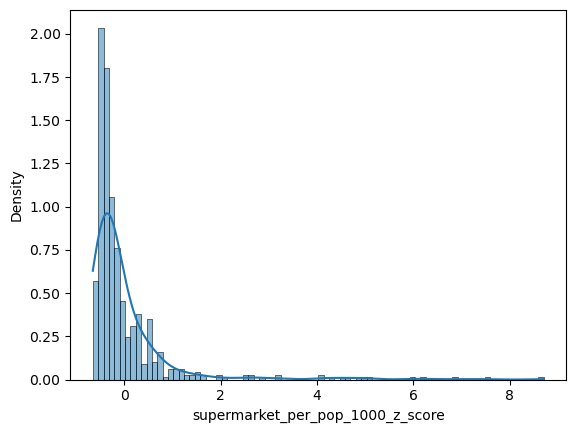

In [578]:
sn.histplot(gdf_hex_pop_supermarket["supermarket_per_pop_1000_z_score"], kde=True, stat="density")
plt.show()

Отобразим результаты анализа на карте с помощью библиотеки folium

In [579]:
#Найдем центральную точку ЮАО для отображения результатов на карте с помощью folium
point_start = okrug.geometry.union_all().centroid

In [580]:
point_start.xy

(array('d', [37.66143593814603]), array('d', [55.63659396452308]))

In [581]:
gdf_hex_pop_supermarket.head(2)

index                                           geometry  \
0  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   
1  8911aa79833ffff  POLYGON ((37.69233 55.68538, 37.69472 55.68432...   

           pop                                    700m_buffer_utm  \
0  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   
1   232.458557  POLYGON ((417091.131 6171932.843, 417118.306 6...   

                                   700m_buffer_wgs84  count_supermarket  \
0  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...                 26   
1  POLYGON ((37.68127 55.6861, 37.68164 55.68792,...                 36   

   supermarket_per_pop_1000  supermarket_per_pop_1000_z_score  \
0                 18.407572                         -0.058437   
1                154.866314                          4.488956   

   rank_supermarket_per_pop_1000  
0                          179.0  
1                           10.0

In [582]:
# Сформируем json с геометрией объектов
geo_data = gpd.GeoSeries(gdf_hex_pop_supermarket.set_index('index')['geometry']).to_json()

Интервалы для классификации гексагонов по атрибуту supermarket_per_pop_1000 рассчитаем так, чтобы в каждую группу попадало примерно одинаковое количество объектов.

In [583]:
num_bins = 10
bins_super_per_pop = list(np.quantile(
    gdf_hex_pop_supermarket['supermarket_per_pop_1000'],
    q=np.linspace(0, 1, num_bins+1)
))

In [584]:
bins_super_per_pop

[np.float64(0.5818171516280203),
 np.float64(4.6581295828671285),
 np.float64(5.930056020523866),
 np.float64(7.395477146521673),
 np.float64(9.06254800441078),
 np.float64(10.737673387012208),
 np.float64(13.587333254322534),
 np.float64(17.52696862068226),
 np.float64(26.556435826361493),
 np.float64(38.24538418298347),
 np.float64(281.33710993972625)]

Вручную зададим интервалы для классификации гексагонов на карте по z-score.

In [585]:
# Минимальное значение z-score
z_min = gdf_hex_pop_supermarket["supermarket_per_pop_1000_z_score"].min()
z_min

-0.6524679375009393

In [586]:
# Максимальное значение z-score
z_max = gdf_hex_pop_supermarket["supermarket_per_pop_1000_z_score"].max()
z_max

8.703506829318764

In [587]:
bins_z_score = [z_min, -0.5, -0.2, 0, 0.2, 0.5, 1, 2, 3, 5, z_max]

In [588]:
m = folium.Map(
    [point_start.y, point_start.x], 
    zoom_start=11, 
    tiles="OpenStreetMap.Mapnik",
    width='80%', 
    height='600px'
)

In [589]:
# Создаем FeatureGroup для каждого слоя
layer1 = folium.FeatureGroup(name='Количество супермаркетов на тысячу жителей', show=True)
layer2 = folium.FeatureGroup(name='z-score', show=False)

# Первый слой
choropleth1 = folium.Choropleth(
    geo_data=geo_data,
    data=gdf_hex_pop_supermarket,
    columns=["index", "supermarket_per_pop_1000"],
    key_on="feature.id",
    fill_color="RdYlGn",
    fill_opacity=0.8,
    line_opacity=0.2,
    bins=bins_super_per_pop,
    legend_name="супермаркетов на 1 тыс. жителей"
)
choropleth1.geojson.add_to(layer1)  # Добавляем только GeoJSON часть

# Второй слой
choropleth2 = folium.Choropleth(
    geo_data=geo_data,
    data=gdf_hex_pop_supermarket,
    columns=["index", "supermarket_per_pop_1000_z_score"],
    key_on="feature.id",
    fill_color="RdYlGn",
    fill_opacity=0.8,
    line_opacity=0.2,
    bins=bins_z_score,
    legend_name="z-score"
)
choropleth2.geojson.add_to(layer2)  # Добавляем только GeoJSON часть

# Добавляем FeatureGroups на карту
layer1.add_to(m)
layer2.add_to(m)

# Добавляем легенды отдельно
m.add_child(choropleth1.color_scale)
m.add_child(choropleth2.color_scale)

# Управление слоями
folium.LayerControl(collapsed=False).add_to(m)

In [590]:
m

### 4.3 Оценка обеспеченности жителей супермаркетами по районам ЮАО

Для получения агрегированной оценки обеспеченности жителей супермаркетами в шаговой доступности по районам ЮАО усредним полученный выше показатель (количество супермаркетов в шаговой доступности на 1000 жителей) по всем гексагонам в составе района. При этом будем считать, что гексагон относится к определенному району, если центр гексагона попадает в границы района.

Шаги:
1. Усреднить показатель supermarket_per_pop_1000 по гексагонам района;
2. Визуализировать результаты на карте.

#### 4.3.1 Расчет усредненного показателя количества магазинов на 1000 жителей по районам

In [591]:
gdf_hex_pop_supermarket.head(2)

index                                           geometry  \
0  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   
1  8911aa79833ffff  POLYGON ((37.69233 55.68538, 37.69472 55.68432...   

           pop                                    700m_buffer_utm  \
0  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   
1   232.458557  POLYGON ((417091.131 6171932.843, 417118.306 6...   

                                   700m_buffer_wgs84  count_supermarket  \
0  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...                 26   
1  POLYGON ((37.68127 55.6861, 37.68164 55.68792,...                 36   

   supermarket_per_pop_1000  supermarket_per_pop_1000_z_score  \
0                 18.407572                         -0.058437   
1                154.866314                          4.488956   

   rank_supermarket_per_pop_1000  
0                          179.0  
1                           10.0

In [592]:
# Создадим копию датафрейма гексагонов, в которую будет добавлена колонка с центроидами гексагонов
gdf_hex_centroid = gdf_hex_pop_supermarket.copy()
gdf_hex_centroid['centroid'] = gdf_hex_centroid["700m_buffer_utm"].centroid

In [593]:
# В качестве поля геометрии зададим координаты центроидов в WGS84
gdf_hex_centroid.set_geometry("centroid", inplace=True)
gdf_hex_centroid.to_crs("epsg:4326", inplace=True)

In [594]:
gdf_hex_centroid.head(2)

index                                           geometry  \
0  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   
1  8911aa79833ffff  POLYGON ((37.69233 55.68538, 37.69472 55.68432...   

           pop                                    700m_buffer_utm  \
0  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   
1   232.458557  POLYGON ((417091.131 6171932.843, 417118.306 6...   

                                   700m_buffer_wgs84  count_supermarket  \
0  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...                 26   
1  POLYGON ((37.68127 55.6861, 37.68164 55.68792,...                 36   

   supermarket_per_pop_1000  supermarket_per_pop_1000_z_score  \
0                 18.407572                         -0.058437   
1                154.866314                          4.488956   

   rank_supermarket_per_pop_1000                   centroid  
0                          179.0  POINT (37.66361 55.64662)  
1                           10.0  POINT (37.69509 55.68614)

In [595]:
# Выполним пространственное соединение центров гексагонов с полигонами районов ЮАО
district_hex = gpd.sjoin(district_pop, gdf_hex_centroid, how="left", predicate="contains")

In [596]:
district_hex.head(2)

geometry           name    Okrug  \
0  POLYGON ((37.58214 55.71099, 37.58227 55.71103...  Донской район  Донской   
0  POLYGON ((37.58214 55.71099, 37.58227 55.71103...  Донской район  Донской   

   Population  index_right0            index  \
0       51202            79  8911aa782abffff   
0       51202           607  8911aa782afffff   

                                      geometry_right          pop  \
0  POLYGON ((37.6152 55.68985, 37.61759 55.68879,...   412.259708   
0  POLYGON ((37.61832 55.69243, 37.62071 55.69137...  2783.884158   

                                     700m_buffer_utm  \
0  POLYGON ((412252.161 6172524.102, 412279.331 6...   
0  POLYGON ((412454.166 6172806.837, 412481.336 6...   

                                   700m_buffer_wgs84  count_supermarket  \
0  POLYGON ((37.60414 55.69056, 37.60451 55.69238...                 17   
0  POLYGON ((37.60726 55.69314, 37.60763 55.69496...                 14   

   supermarket_per_pop_1000  supermarket_per_pop_1000_z_score  \
0                 41.236142                          0.702309   
0                  5.028945                         -0.504271   

   rank_supermarket_per_pop_1000  
0                           52.0  
0                          532.0

In [597]:
# Сгруппируем строки по названию района ЮАО и усредним показатели обеспеченности жителей супермаркетами
district_hex_final = district_hex.groupby('name')[['geometry', 'name', 'Population', 'count_supermarket', 'supermarket_per_pop_1000']].agg({'geometry': 'first', 'Population': 'first', 'count_supermarket': 'mean', 'supermarket_per_pop_1000': 'mean'})
district_hex_final

geometry  \
name                                                                                 
Даниловский район                POLYGON ((37.60616 55.71067, 37.60614 55.71082...   
Донской район                    POLYGON ((37.58214 55.71099, 37.58227 55.71103...   
Нагорный район                   POLYGON ((37.60374 55.69052, 37.60437 55.69028...   
Орехово-Борисово Южное           POLYGON ((37.69141 55.60691, 37.69189 55.60699...   
район Бирюлёво Восточное         POLYGON ((37.64072 55.6105, 37.64095 55.61063,...   
район Бирюлёво Западное          POLYGON ((37.61313 55.57463, 37.61456 55.58613...   
район Братеево                   POLYGON ((37.72712 55.6353, 37.72717 55.6353, ...   
район Зябликово                  POLYGON ((37.72739 55.62709, 37.7274 55.6271, ...   
район Москворечье-Сабурово       POLYGON ((37.62246 55.65753, 37.62423 55.65723...   
район Нагатино-Садовники         POLYGON ((37.62186 55.69073, 37.62236 55.69083...   
район Нагатинский Затон          POLYGON ((37.65944 55.65064, 37.65849 55.65112...   
район Орехово-Борисово Северное  POLYGON ((37.67139 55.61998, 37.67129 55.62003...   
район Царицыно                   POLYGON ((37.62507 55.63998, 37.62587 55.64003...   
район Чертаново Северное         POLYGON ((37.57757 55.63445, 37.57778 55.6347,...   
район Чертаново Центральное      POLYGON ((37.57002 55.6072, 37.5699 55.60724, ...   
район Чертаново Южное            POLYGON ((37.57368 55.58221, 37.57561 55.58391...   

                                 Population  count_supermarket  \
name                                                             
Даниловский район                    104718          27.021739   
Донской район                         51202          18.840000   
Нагорный район                        76015          20.575758   
Орехово-Борисово Южное               146515          31.025641   
район Бирюлёво Восточное             155760          29.617021   
район Бирюлёво Западное               84910          26.181818   
район Братеево                       100282          31.034483   
район Зябликово                      133650          28.512821   
район Москворечье-Сабурово            87843          24.360000   
район Нагатино-Садовники              83794          24.404762   
район Нагатинский Затон              121411          32.268293   
район Орехово-Борисово Северное      124071          31.750000   
район Царицыно                       117967          24.844444   
район Чертаново Северное             109627          27.133333   
район Чертаново Центральное          111581          29.975000   
район Чертаново Южное                156178          30.542373   

                                 supermarket_per_pop_1000  
name                                                       
Даниловский район                               31.355498  
Донской район                                   21.041951  
Нагорный район                                  19.985391  
Орехово-Борисово Южное                          10.784113  
район Бирюлёво Восточное                        19.401744  
район Бирюлёво Западное                         15.162103  
район Братеево                                  10.649878  
район Зябликово                                 11.277424  
район Москворечье-Сабурово                      22.483834  
район Нагатино-Садовники                        40.174058  
район Нагатинский Затон                         21.907196  
район Орехово-Борисово Северное                 14.610003  
район Царицыно                                  28.268343  
район Чертаново Северное                        12.340574  
район Чертаново Центральное                     17.989497  
район Чертаново Южное                           17.890153

In [598]:
# Укажем поле геометрии
district_hex_final.set_geometry('geometry', inplace=True)

In [599]:
district_hex_final.set_crs("epsg:4326", inplace=True)

geometry  \
name                                                                                 
Даниловский район                POLYGON ((37.60616 55.71067, 37.60614 55.71082...   
Донской район                    POLYGON ((37.58214 55.71099, 37.58227 55.71103...   
Нагорный район                   POLYGON ((37.60374 55.69052, 37.60437 55.69028...   
Орехово-Борисово Южное           POLYGON ((37.69141 55.60691, 37.69189 55.60699...   
район Бирюлёво Восточное         POLYGON ((37.64072 55.6105, 37.64095 55.61063,...   
район Бирюлёво Западное          POLYGON ((37.61313 55.57463, 37.61456 55.58613...   
район Братеево                   POLYGON ((37.72712 55.6353, 37.72717 55.6353, ...   
район Зябликово                  POLYGON ((37.72739 55.62709, 37.7274 55.6271, ...   
район Москворечье-Сабурово       POLYGON ((37.62246 55.65753, 37.62423 55.65723...   
район Нагатино-Садовники         POLYGON ((37.62186 55.69073, 37.62236 55.69083...   
район Нагатинский Затон          POLYGON ((37.65944 55.65064, 37.65849 55.65112...   
район Орехово-Борисово Северное  POLYGON ((37.67139 55.61998, 37.67129 55.62003...   
район Царицыно                   POLYGON ((37.62507 55.63998, 37.62587 55.64003...   
район Чертаново Северное         POLYGON ((37.57757 55.63445, 37.57778 55.6347,...   
район Чертаново Центральное      POLYGON ((37.57002 55.6072, 37.5699 55.60724, ...   
район Чертаново Южное            POLYGON ((37.57368 55.58221, 37.57561 55.58391...   

                                 Population  count_supermarket  \
name                                                             
Даниловский район                    104718          27.021739   
Донской район                         51202          18.840000   
Нагорный район                        76015          20.575758   
Орехово-Борисово Южное               146515          31.025641   
район Бирюлёво Восточное             155760          29.617021   
район Бирюлёво Западное               84910          26.181818   
район Братеево                       100282          31.034483   
район Зябликово                      133650          28.512821   
район Москворечье-Сабурово            87843          24.360000   
район Нагатино-Садовники              83794          24.404762   
район Нагатинский Затон              121411          32.268293   
район Орехово-Борисово Северное      124071          31.750000   
район Царицыно                       117967          24.844444   
район Чертаново Северное             109627          27.133333   
район Чертаново Центральное          111581          29.975000   
район Чертаново Южное                156178          30.542373   

                                 supermarket_per_pop_1000  
name                                                       
Даниловский район                               31.355498  
Донской район                                   21.041951  
Нагорный район                                  19.985391  
Орехово-Борисово Южное                          10.784113  
район Бирюлёво Восточное                        19.401744  
район Бирюлёво Западное                         15.162103  
район Братеево                                  10.649878  
район Зябликово                                 11.277424  
район Москворечье-Сабурово                      22.483834  
район Нагатино-Садовники                        40.174058  
район Нагатинский Затон                         21.907196  
район Орехово-Борисово Северное                 14.610003  
район Царицыно                                  28.268343  
район Чертаново Северное                        12.340574  
район Чертаново Центральное                     17.989497  
район Чертаново Южное                           17.890153

In [600]:
district_hex_final["rank_supermarket_per_pop_1000"] = district_hex_final.supermarket_per_pop_1000.rank(ascending=False)

In [601]:
# Топ-3 районов по количеству супермаркетов на 1000 жителей
district_hex_final_best = district_hex_final.query("`rank_supermarket_per_pop_1000` <= 3").sort_values("rank_supermarket_per_pop_1000")

In [602]:
district_hex_final_best

geometry  \
name                                                                          
район Нагатино-Садовники  POLYGON ((37.62186 55.69073, 37.62236 55.69083...   
Даниловский район         POLYGON ((37.60616 55.71067, 37.60614 55.71082...   
район Царицыно            POLYGON ((37.62507 55.63998, 37.62587 55.64003...   

                          Population  count_supermarket  \
name                                                      
район Нагатино-Садовники       83794          24.404762   
Даниловский район             104718          27.021739   
район Царицыно                117967          24.844444   

                          supermarket_per_pop_1000  \
name                                                 
район Нагатино-Садовники                 40.174058   
Даниловский район                        31.355498   
район Царицыно                           28.268343   

                          rank_supermarket_per_pop_1000  
name                                                     
район Нагатино-Садовники                            1.0  
Даниловский район                                   2.0  
район Царицыно                                      3.0

In [603]:
# Три наихудших района по количеству супермаркетов на 1000 жителей
max_rank = district_hex_final.rank_supermarket_per_pop_1000.max()
district_hex_final_worst = district_hex_final.query("`rank_supermarket_per_pop_1000` >= (@max_rank - 2)").sort_values("rank_supermarket_per_pop_1000", ascending=False)

In [604]:
district_hex_final_worst.head(3)

geometry  \
name                                                                        
район Братеево          POLYGON ((37.72712 55.6353, 37.72717 55.6353, ...   
Орехово-Борисово Южное  POLYGON ((37.69141 55.60691, 37.69189 55.60699...   
район Зябликово         POLYGON ((37.72739 55.62709, 37.7274 55.6271, ...   

                        Population  count_supermarket  \
name                                                    
район Братеево              100282          31.034483   
Орехово-Борисово Южное      146515          31.025641   
район Зябликово             133650          28.512821   

                        supermarket_per_pop_1000  \
name                                               
район Братеево                         10.649878   
Орехово-Борисово Южное                 10.784113   
район Зябликово                        11.277424   

                        rank_supermarket_per_pop_1000  
name                                                   
район Братеево                                   16.0  
Орехово-Борисово Южное                           15.0  
район Зябликово                                  14.0

In [605]:
# Сохраним результаты расчетов в файл
district_hex_final.to_file("./data/processed/district_hex_final.geojson", driver='GeoJSON')

#### 4.3.2 Визуализация результатов

Визуализируем результаты на карте с помощью библиотеки Matplotlib. Предварительно спроецируем district_hex_final в систему координат EPSG:3857.

Text(0.5, 1.0, 'Количество супермаркетов на 1000 жителей по районам')

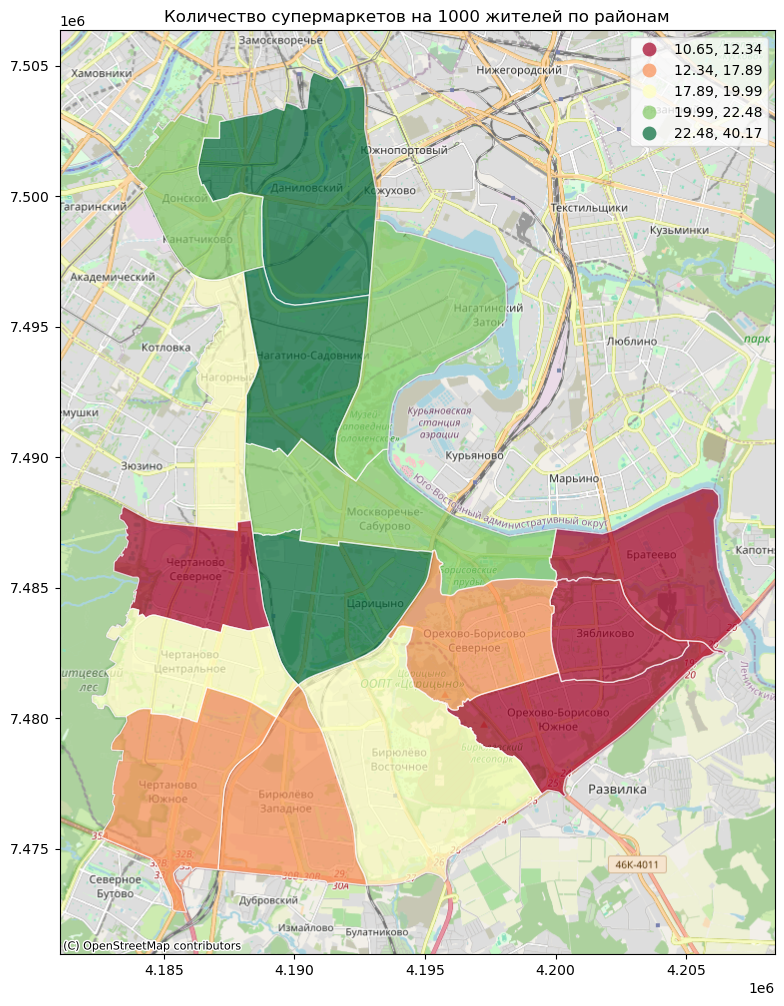

In [606]:
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(12,12))
district_hex_final.to_crs("EPSG:3857").plot(ax=ax, column="supermarket_per_pop_1000", scheme="quantiles", k=5, cmap='RdYlGn', edgecolor='white', alpha=0.7, legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Количество супермаркетов на 1000 жителей по районам")

## 5. Подбор перспективных локаций для нового супермаркета

Пусть имеется задача подбора локации для открытия нового супермаркета. Оценок, полученных на предыдущих шагах (количество магазинов в шаговой доступности на 1000 жителей), недостаточно для оценки перспективности локации, так как эти оценки не отражают, сколько покупателей потенциально придет в случае открытия нового магазина. В гексагонах с низкоэтажной застрокой может быть невыгодно открывать магазин даже в том случае, если в окрестности нет ни одного магазина, так как покупателей в любом случае будет мало, хотя по оценке supermarket_per_pop_1000 данная локация может выглядеть перспективной.

Поэтому проведем оценку посещаемости новой локации с использованием гравитационной модели Хаффа. В качестве возможных локаций будем рассматривать центры гексагонов, причем отберем только те гексагоны, в которых имеются какие-либо строения (чтобы отсечь, как минимум, парковые зоны, где открытие супермаркета в большинстве случаев невозможно).
В качестве точек проживания потребителей также будем брать центры гексагонов, считая, что в этих точках сосредоточено все население гексагона.

Процесс подбора перспективных локаций будет включать следующие шаги:
1. Отобрать потенциальные локаций для супермаркета (гексагоны, расположенные вне парковых зон и содержащие какие-либо строения);
2. Написать функцию расчета посещаемости для набора магазинов и точек проживания населения;
3. Рассчитать посещаемость для потенциальных локаций магазинов;
4. Визуализировать результаты на карте.

### 5.1 Отбор потенциальных локаций для супермаркета

В качестве возможных локаций для супермаркета будем рассматривать центры гексагонов ЮАО, при этом исключим те гексагоны, в которых отсуствуют какие-либо строения либо имеющиеся строения расположены в парковых зонах.

In [607]:
# Все гексагоны ЮАО хранятся в геодатафрейме gdf_hex
gdf_hex.head(2)

index                                           geometry
0  891181b61b7ffff  POLYGON ((37.63167 55.61724, 37.63405 55.61618...
1  8911aa79393ffff  POLYGON ((37.6249 55.64795, 37.62729 55.64689,...

In [608]:
# Найдем строения, находящиеся целиком внутри парков
buildings_within_parks = gpd.sjoin(
    buildings_uao_all,
    parks,
    how="inner",
    predicate="within"
)

In [609]:
buildings_within_parks.head(2)

id_left                   geometry  index_right  id_right
12  3564396757   POINT (37.7016 55.62723)            6   1944925
13  3648728761  POINT (37.69809 55.62579)            6   1944925

In [610]:
buildings_within_parks.shape

(599, 4)

In [611]:
# Исключим из списка строений те, которые были отобраны выше - получим строения, расположенные вне парковых зон (полностью или частично)
list_park_buldings = buildings_within_parks.id_left.to_list()
buildings_outside_parks = buildings_uao_all.query('`id` not in @list_park_buldings')

In [612]:
buildings_outside_parks.shape

(15842, 2)

In [613]:
# Проверим геометрию гексагонов
gdf_hex.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [614]:
# Проверим геометрию зданий вне парков
buildings_outside_parks.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [615]:
#Отбираем гексагоны, пересекающие хотя бы одно здание вне парка
gdf_hex_with_buildings = gpd.sjoin(
    gdf_hex, 
    buildings_outside_parks, 
    how="inner",
    predicate="intersects" 
)

In [616]:
# Убираем дубликаты гексагонов (могут образоваться, если один гексагон содержит несколько зданий)
gdf_hex_with_buildings = gdf_hex_with_buildings[~gdf_hex_with_buildings.index.duplicated(keep='first')]

In [617]:
gdf_hex_with_buildings.explore()

In [618]:
# Добавим коодинаты центроидов
gdf_hex_with_buildings["centroid_utm"] = gdf_hex_with_buildings["geometry"].to_crs(utm).centroid
gdf_hex_with_buildings["centroid"] = gdf_hex_with_buildings["centroid_utm"].to_crs("EPSG:4326")

In [619]:
gdf_hex_with_buildings.head(2)

index                                           geometry  \
0  891181b61b7ffff  POLYGON ((37.63167 55.61724, 37.63405 55.61618...   
1  8911aa79393ffff  POLYGON ((37.6249 55.64795, 37.62729 55.64689,...   

   index_right        id                    centroid_utm  \
0         5472  62120140  POINT (413996.297 6164410.672)   
1         4940  51503043  POINT (413638.218 6167836.831)   

                    centroid  
0  POINT (37.63442 55.61799)  
1  POINT (37.62766 55.64871)

In [620]:
del buildings_uao_all, buildings_within_parks, gdf_hex

### 5.2 Функция расчета посещаемости магазина

Для расчета посещаемости магазина будем использовать гравитационную модель Хаффа, которая предполагает, что вероятность посещения покупателями некоторого магазина пропорциональна привлекательности этого магазина и обратно пропорциональна расстоянию/времени до магазина (возможно, с некоторыми показателями степени).

Будем использовать формулу Хаффа в следующей модификации:

$
P_{ij} = \frac{A_j \cdot D_{ij}^{-1}}{\sum_{k=1}^n A_k \cdot D_{ik}^{-1}}
$

где:

- $P_{ij}$ - вероятность того, что покупатель из локации i пойдет в магазин j;
 - $A_j$ - привлекательность магазина j;
- $D_{ij}$ - расстояние от локации покупателя до магазина;
- n - количество магазинов.

Будем предполагать, что привлекательность магазина ($A_j$ в формуле) для посетителей зависит от типа магазина, определяемого атрибутами TypeObject и IsNetObject:
- сетевые гипермаркеты - привлекательность 3;
- несетевые гипермаркеты и сетевые магазины-не гипермаркеты - привлекательность 2;
- прочие магазины - привлекательность 1.

Для целей данной работы не будем учитывать другие показатели, влияющие на привлекательность магазина: торговая площадь, ассортимент, близость к транспортным узлам и точкам интереса и т. д.

Расстояние от локации покупателя до магазина будем считать по прямой. При этом будем предполагать, что покупатель не пойдет в магазин, расположенный далее чем 700 метров от его дома.

In [621]:
supermarket_gdf.columns

Index(['geometry', 'global_id', 'Name', 'IsNetObject', 'TypeObject',
       'Address'],
      dtype='object')

In [622]:
# Атрибут "Тип магазина"
supermarket_gdf.TypeObject.value_counts()

TypeObject
Магазин «Продукты»                 558
Универсам                          418
Супермаркет                        135
Гипермаркет (продовольственный)     18
Гастроном                            3
Name: count, dtype: int64

In [623]:
# Атрибут "Является ли сетевым объектом"
supermarket_gdf.IsNetObject.value_counts()

IsNetObject
да     728
нет    404
Name: count, dtype: int64

Добавим для датафрейма супермаркетов поле с привлекательностью

In [624]:
supermarket_gdf_attract = supermarket_gdf.copy()

In [625]:
# Большинство магазинов будет иметь привлекательность 1 и 2, внесем их в геодатафрейм
supermarket_gdf_attract["attract"] = supermarket_gdf_attract.IsNetObject.apply(lambda x: 2 if x=="да" else 1)

In [626]:
# Для сетевых гипермаркетов изменим привлекательность на 3
supermarket_gdf_attract.loc[(supermarket_gdf_attract["TypeObject"] == "Гипермаркет (продовольственный)") & (supermarket_gdf_attract["IsNetObject"] == "да"), "attract"] = 3

In [627]:
supermarket_gdf_attract.attract.value_counts()

attract
2    711
1    404
3     17
Name: count, dtype: int64

Поскольку нам будет необходимо рассчитывать расстояния от локаций покупателей до магазинов, то конвертируем данные в EPSG:32637 (сохранено в переменной utm).

In [628]:
#Переведем геодатафрейм супермаркетов в UTM
supermarket_gdf_attract['geometry_utm'] = supermarket_gdf_attract.geometry.to_crs(utm)
supermarket_gdf_attract.set_geometry('geometry_utm', inplace=True)

In [629]:
#Переведем геодатафрейм гексагонов в UTM, будем использовать центроиды в качестве локации населения
gdf_hex_with_buildings.set_geometry("centroid_utm", inplace=True)
gdf_hex_with_buildings.head(2)

index                                           geometry  \
0  891181b61b7ffff  POLYGON ((37.63167 55.61724, 37.63405 55.61618...   
1  8911aa79393ffff  POLYGON ((37.6249 55.64795, 37.62729 55.64689,...   

   index_right        id                    centroid_utm  \
0         5472  62120140  POINT (413996.297 6164410.672)   
1         4940  51503043  POINT (413638.218 6167836.831)   

                    centroid  
0  POINT (37.63442 55.61799)  
1  POINT (37.62766 55.64871)

In [630]:
# Добавим поле с геометрией гексагона в utm
gdf_hex_with_buildings.loc[:, "geometry_utm"] = gdf_hex_with_buildings["geometry"].to_crs(utm)

In [631]:
# Все поля с геометрией в gdf_hex_with_buildings
list(gdf_hex_with_buildings.select_dtypes(include=['geometry']).columns)

['geometry', 'centroid_utm', 'centroid', 'geometry_utm']

Напишем функцию, которая для двух геодатафреймов - локации покупателей и точки магазинов - создает таблицу посещаемости для каждой пары локация покупателей - магазин в пределах шаговой доступности от локаций покупателей.

In [632]:
def visitors_per_super(population, supermarkets, buf=700):
    """ Функция расчета посещаемости для локаций населения и магазинов. 
    Функция принимает параметры: 
    - population - геодатафрейм с локациями населения (геометрия в utm - поля geometry_utm и centroid_utm, численность населения - поле pop);
    - supermarkets - точки магазинов (геометрия в utm - поле geometry_utm, уровень привлекательности - поле attract);
    - buf - радиус шаговой доступности для населения в метрах, по умолчанию 700 метров.
    Функция возвращает таблицу с результатами расчета посещаемости для пар локация населения - магазин. Атрибуты в таблице:
    - pop_id - идентификатор локации населения из таблицы population;
    - population - численность населения в данной локации;
    - supermarket_id - идентификатор магазина из таблицы supermarkets;
    - distance - расстояние от локации до магазина (в метрах);
    - a_d - отношение привлекательности магазина к расстоянию между магазином и локацией покупателя. Это числитель в формуле Хаффа;
    - sum_a_d - сумма показателей a_d для всех магазинов в шаговой доступности от данной локации покупателя (т.е. в пределах буферной зоны радиуса buf от гексагона покупателя).
    Это знаменатель в формуле Хаффа;
    - probability - вероятность посещения покупателем из данной локации указанного магазина, рассчитанная по формуле Хаффа выше;
    - visitors - количество посетителей магазина из данной локации населения.
    """
    
    #Создадим датафрейм, куда будем записывать результаты расчетов
    res = pd.DataFrame(columns=["pop_id", "population", "supermarket_id", "distance", "a_d", "sum_a_d", "probability", "visitors"])
    
    # Цикл по всем локациям покупателям 
    for indx, row in population.iterrows():
        # Найдем все магазины в радиусе buf от гексагона с покупателями (то есть в шаговой доступности)
        supermarkets_buf = supermarkets[supermarkets.within(row.geometry_utm.buffer(700))]

        # Цикл по супермаркетам в буферной зоне
        for ind, r in supermarkets_buf.iterrows():
            # Расстояние между локацией покупателей и магазином
            distance = shapely.distance(row.centroid_utm, r.geometry_utm)
            
            # Если расстояние равно нулю, то будем считать его равным 100 (чтобы избежать деления на 0 в расчетах)
            denom = (distance if distance !=0 else 100)
            # Числитель в формуле Хаффа
            a_d =  r.attract / denom

            # Добавляем новую запись в таблицу для изучаемой пары локация-магазин. Последние три атрибута пока нулевые - они будут рассчитаны позже.
            res.loc[len(res)] = [row["index"], row["pop"], r["global_id"], distance, a_d, 0.0, 0.0, 0.0]
        
        # Знаменатель в формуле Хаффа
        sum_a_d = res.loc[res["pop_id"] == row["index"]].a_d.sum()
        res.loc[res["pop_id"] == row["index"], 'sum_a_d'] = sum_a_d
        res.probability = res.apply(lambda x: x.a_d / x.sum_a_d, axis=1)
        res.visitors = res.apply(lambda x: x.population * x.probability, axis=1)
    return(res)

In [633]:
del supermarket_gdf

In [634]:
gc.collect()

99

### 5.3 Расчет посещаемости для потенциальных локаций магазинов

Пусть нас интересует размещение одного нового сетевого супермаркета, то есть привлекательность этого магазина по нашим критериям будет равна 2.

Будем отдельно рассматривать каждую из потенциальных локаций магазинов и, добавив ее в перечень существующих супермаркетов, запускать приведенную выше функцию расчета посещаемости.

Расчет посещаемости для потенциальных локаций магазинов будет включать следующие шаги:
1. Выбрать одну из потенциальных локаций магазина (в цикле по всем потенциальным локациям);
2. С помощью подготовленной выше функции рассчитать посещаемость нового магазина для каждой из локаций жителей в зоне шаговой доступности;
3. Просуммировать количество посетителей нового магазина для всех локаций жителей в шаговой доступности;
4. Повторить шаги 1-3 в цикле по всем потенциальным локациям магазинов;
5. Сравнить суммарную посещаемость магазинов и выбрать наиболее перспективные места для открытия нового магазина.

Центроиды гексагонов уже были посчитаны ранее в датафрейме gdf_hex_centroid. В этом же датафрейме содержатся данные о суммарной численности населения гексагона.

In [636]:
#Зададим радиус пешей доступности (в метрах)
buf = 700

In [637]:
#Пересчитаем индексы для супермаркетов
supermarket_gdf_attract.reset_index(drop=True, inplace=True)

In [638]:
# Создадим копию геодатафрейма с локациями для сохранения рассчитанной посещаемости нового магазина
gdf_hex_with_estimation = gdf_hex_with_buildings.copy()

In [639]:
#Создаем копию таблицы супермаркетов с одной пустой сторокой, куда будем записывать рассматриваемую потенциальную локацию магазина
supermarkets_with_new = supermarket_gdf_attract.copy()
new_row = {col: pd.NA for col in supermarkets_with_new.columns}
new_row['geometry_utm'] = None
supermarkets_with_new.loc[len(supermarkets_with_new)] = new_row

C:\Users\user\AppData\Local\Temp\ipykernel_10348\3216419041.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  supermarkets_with_new.loc[len(supermarkets_with_new)] = new_row


In [640]:
gdf_hex_with_estimation.head(2)

index                                           geometry  \
0  891181b61b7ffff  POLYGON ((37.63167 55.61724, 37.63405 55.61618...   
1  8911aa79393ffff  POLYGON ((37.6249 55.64795, 37.62729 55.64689,...   

   index_right        id                    centroid_utm  \
0         5472  62120140  POINT (413996.297 6164410.672)   
1         4940  51503043  POINT (413638.218 6167836.831)   

                    centroid  \
0  POINT (37.63442 55.61799)   
1  POINT (37.62766 55.64871)   

                                        geometry_utm  
0  POLYGON ((413821.425 6164329.631, 413969.124 6...  
1  POLYGON ((413463.36 6167755.761, 413611.045 61...

In [641]:
gdf_hex_centroid.head(2)

index                                           geometry  \
0  891181b6d93ffff  POLYGON ((37.66086 55.64586, 37.66324 55.6448,...   
1  8911aa79833ffff  POLYGON ((37.69233 55.68538, 37.69472 55.68432...   

           pop                                    700m_buffer_utm  \
0  1412.462241  POLYGON ((415027.72 6167572.649, 415054.893 61...   
1   232.458557  POLYGON ((417091.131 6171932.843, 417118.306 6...   

                                   700m_buffer_wgs84  count_supermarket  \
0  POLYGON ((37.64981 55.64658, 37.65018 55.6484,...                 26   
1  POLYGON ((37.68127 55.6861, 37.68164 55.68792,...                 36   

   supermarket_per_pop_1000  supermarket_per_pop_1000_z_score  \
0                 18.407572                         -0.058437   
1                154.866314                          4.488956   

   rank_supermarket_per_pop_1000                   centroid  
0                          179.0  POINT (37.66361 55.64662)  
1                           10.0  POINT (37.69509 55.68614)

In [645]:
# Добавим к "обитаемым" гексагонам с центроидами (gdf_hex_centroid) поля геометрии в проекции UTM
gdf_hex_centroid["geometry_utm"] = gdf_hex_centroid["geometry"].to_crs(utm)
gdf_hex_centroid["centroid_utm"] = gdf_hex_centroid["centroid"].to_crs(utm)

In [646]:
supermarkets_with_new.head()

geometry  global_id                             Name  \
0  POINT (37.62518 55.71118)  637392270                 Монастырский мед   
1   POINT (37.6943 55.63982)  637395486                            Дикси   
2  POINT (37.59952 55.60483)  637396280                         Продукты   
3  POINT (37.66435 55.59212)  637435648  Магазин «Продукты, овощи-фрукты   
4   POINT (37.66241 55.7086)  637624248                            Дикси   

  IsNetObject          TypeObject  \
0         нет  Магазин «Продукты»   
1          да           Универсам   
2         нет  Магазин «Продукты»   
3         нет  Магазин «Продукты»   
4          да           Универсам   

                                             Address attract  \
0  Российская Федерация, город Москва, внутригоро...       1   
1  Российская Федерация, город Москва, внутригоро...       2   
2         город Москва, Кировоградская улица, дом 36       1   
3  Российская Федерация, город Москва, внутригоро...       1   
4  Российская Федерация, город Москва, внутригоро...       2   

                     geometry_utm  
0   POINT (413620.311 6174791.33)  
1  POINT (417813.505 6166767.304)  
2  POINT (411768.918 6162989.962)  
3  POINT (415825.918 6161494.469)  
4  POINT (415953.472 6174458.573)

In [647]:
#Цикл по гексагонам - потенциальным локациям
for hex_ind, hex_row in gdf_hex_with_estimation.iterrows():
    location = hex_row.centroid_utm
    visitors_points = gdf_hex_centroid[gdf_hex_centroid.geometry_utm.buffer(buf).contains(location)]
    supermarkets_with_new.iloc[-1] = {"global_id": 0, "attract": 2, "geometry_utm": location}
    res = visitors_per_super(visitors_points, supermarkets_with_new, buf)
    gdf_hex_with_estimation.loc[hex_ind, "estimation"] = res.loc[res["supermarket_id"] == 0].visitors.sum()

In [648]:
gdf_hex_with_estimation["rank_estimation"] = gdf_hex_with_estimation.estimation.rank(ascending=False)

In [649]:
# Топ-10 новых локаций по количеству посетителей
gdf_hex_with_estimation_best = gdf_hex_with_estimation.query("`rank_estimation` <= 10").sort_values("rank_estimation")

In [650]:
gdf_hex_with_estimation_best

index                                           geometry  \
288   891181b6e83ffff  POLYGON ((37.65823 55.60742, 37.66062 55.60636...   
795   8911aa7913bffff  POLYGON ((37.63648 55.66657, 37.63886 55.66552...   
429   891181b6cabffff  POLYGON ((37.65753 55.62951, 37.65992 55.62846...   
337   891181b637bffff  POLYGON ((37.65783 55.57987, 37.66021 55.57881...   
637   8911aa78297ffff  POLYGON ((37.59978 55.69074, 37.60217 55.68968...   
1289  891181b6dc3ffff  POLYGON ((37.6669 55.63724, 37.66928 55.63618,...   
1205  891181b6dd3ffff  POLYGON ((37.66176 55.63754, 37.66415 55.63648...   
84    891181b4503ffff  POLYGON ((37.68458 55.58381, 37.68696 55.58276...   
1212  8911aa79873ffff  POLYGON ((37.69323 55.67706, 37.69562 55.676, ...   
976   8911aa7936bffff  POLYGON ((37.65663 55.63784, 37.65901 55.63678...   

      index_right          id                    centroid_utm  \
288         10382   299770182  POINT (415648.379 6163285.372)   
795          4756    50576050  POINT (414407.347 6169894.914)   
429          1982    31025638  POINT (415651.805 6165745.155)   
337         11089   327312101   POINT (415563.45 6160220.354)   
637          2803    32609260  POINT (412153.283 6172629.928)   
1289          793    23410654  POINT (416258.054 6166593.406)   
1205        15132   988100851  POINT (415935.402 6166632.943)   
84            164     1744932  POINT (417258.423 6160627.122)   
1212          158     1412042  POINT (417998.872 6170993.174)   
976         16225  1356184462  POINT (415612.764 6166672.478)   

                       centroid  \
288   POINT (37.66098 55.60818)   
795   POINT (37.63923 55.66733)   
429   POINT (37.66029 55.63027)   
337   POINT (37.66058 55.58063)   
637    POINT (37.60253 55.6915)   
1289    POINT (37.66965 55.638)   
1205   POINT (37.66452 55.6383)   
84    POINT (37.68733 55.58457)   
1212  POINT (37.69599 55.67782)   
976    POINT (37.65938 55.6386)   

                                           geometry_utm    estimation  \
288   POLYGON ((415473.469 6163204.333, 415621.205 6...  29317.674911   
795   POLYGON ((414232.477 6169813.821, 414380.173 6...  25071.504707   
429   POLYGON ((415476.9 6165664.094, 415624.63 6165...  17729.380005   
337   POLYGON ((415388.536 6160139.344, 415536.276 6...  14225.983915   
637   POLYGON ((411978.467 6172548.822, 412126.111 6...  12700.442959   
1289  POLYGON ((416083.138 6166512.333, 416230.879 6...  12268.333699   
1205  POLYGON ((415760.493 6166551.872, 415908.227 6...  11438.148596   
84    POLYGON ((417083.473 6160546.099, 417231.247 6...  10742.064743   
1212  POLYGON ((417823.928 6170912.053, 417971.695 6...  10258.077621   
976   POLYGON ((415437.862 6166591.408, 415585.589 6...  10097.605165   

      rank_estimation  
288               1.0  
795               2.0  
429               3.0  
337               4.0  
637               5.0  
1289              6.0  
1205              7.0  
84                8.0  
1212              9.0  
976              10.0

In [651]:
# Проверим колонки с геометрией
list(gdf_hex_with_estimation.select_dtypes(include=['geometry']).columns)

['geometry', 'centroid_utm', 'centroid', 'geometry_utm']

In [653]:
# Сохраним результат в файл, оставив только поле с геометрией гексагонов в WGS:84
gdf_hex_with_estimation.drop(columns=['centroid', 'centroid_utm', 'geometry_utm']).to_file('./data/processed/gdf_hex_with_estimation.geojson', driver='GeoJSON', encoding='utf-8')

In [654]:
del supermarkets_with_new, gdf_hex_centroid

In [655]:
gc.collect()

9297

### 5.4 Визуализация результатов

Построим гистограмму распределения показателя количество посетителей новой локации.

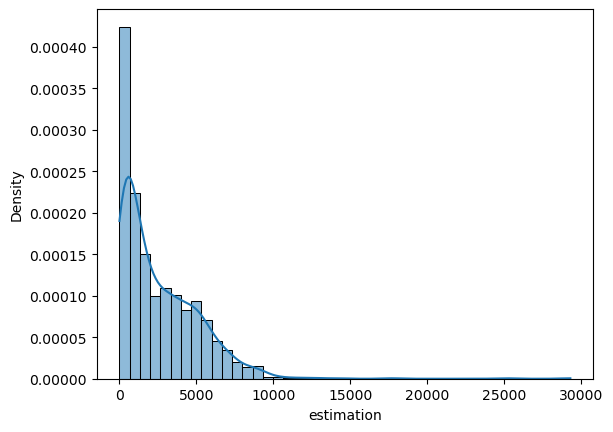

In [656]:
sn.histplot(gdf_hex_with_estimation["estimation"], kde=True, stat="density")
plt.show()

Отобразим результаты анализа на карте с помощью библиотеки folium.

In [657]:
#Найдем центральную точку ЮАО для отображения результатов на карте с помощью folium
point_start = okrug.geometry.union_all().centroid

In [658]:
gdf_hex_with_estimation.head(2)

index                                           geometry  \
0  891181b61b7ffff  POLYGON ((37.63167 55.61724, 37.63405 55.61618...   
1  8911aa79393ffff  POLYGON ((37.6249 55.64795, 37.62729 55.64689,...   

   index_right        id                    centroid_utm  \
0         5472  62120140  POINT (413996.297 6164410.672)   
1         4940  51503043  POINT (413638.218 6167836.831)   

                    centroid  \
0  POINT (37.63442 55.61799)   
1  POINT (37.62766 55.64871)   

                                        geometry_utm  estimation  \
0  POLYGON ((413821.425 6164329.631, 413969.124 6...  371.144615   
1  POLYGON ((413463.36 6167755.761, 413611.045 61...  512.776777   

   rank_estimation  
0            951.0  
1            899.0

In [659]:
# Сформируем json с геометрией объектов
geo_data = gpd.GeoSeries(gdf_hex_with_estimation.set_index('index')['geometry']).to_json()

In [660]:
geo_data_2 = gpd.GeoSeries(gdf_hex_with_estimation_best.set_index('index')['geometry']).to_json()

Интервалы для классификации гексагонов по атрибуту estimation рассчитаем так, чтобы в каждую группу попадало примерно одинаковое количество объектов. Также нанесем на карту топ-10 гексагонов по посещаемости.

In [661]:
num_bins = 10
bins_estimation = list(np.quantile(
    gdf_hex_with_estimation['estimation'],
    q=np.linspace(0, 1, num_bins+1)
))

In [662]:
bins_estimation

[np.float64(0.0),
 np.float64(149.54660816619202),
 np.float64(397.63452601459335),
 np.float64(717.8061997411646),
 np.float64(1166.523555122469),
 np.float64(1776.286853633685),
 np.float64(2669.7608994757425),
 np.float64(3603.533047665913),
 np.float64(4713.886754866607),
 np.float64(5925.644072893576),
 np.float64(29317.674910781046)]

In [669]:
m = folium.Map(
    [point_start.y, point_start.x], 
    zoom_start=11, 
    tiles="OpenStreetMap.Mapnik",
    width='80%',  
    height='600px'
)

In [670]:
# Создаем FeatureGroup для каждого слоя
layer1 = folium.FeatureGroup(name='Количество посетитей при открытии нового магазина', show=True)
layer2 = folium.FeatureGroup(name='Наиболее перспективные локации нового магазина', show=False)

# Первый слой
choropleth1 = folium.Choropleth(
    geo_data=geo_data,
    data=gdf_hex_with_estimation,
    columns=["index", "estimation"],
    key_on="feature.id",
    fill_color="RdYlGn",
    fill_opacity=0.8,
    line_opacity=0.2,
    bins=bins_estimation,
    legend_name="кол-во посетителей нового магазина"
)
choropleth1.geojson.add_to(layer1)  # Добавляем только GeoJSON часть

# Второй слой
style_function = lambda x: {
    'fillColor': '#0000FF',  
    'color': '#000000',  
    'fillOpacity': 0.8,
    'weight': 0.2
}

# Создаем GeoJson для второго слоя с единым стилем
choropleth2_geojson = folium.GeoJson(
    geo_data_2,
    style_function=style_function,
    name='Наиболее перспективные локации'
)
choropleth2_geojson.add_to(layer2)

# Добавляем FeatureGroups на карту
layer1.add_to(m)
layer2.add_to(m)

# Добавляем легенды отдельно
m.add_child(choropleth1.color_scale)

# Управление слоями
folium.LayerControl(collapsed=False).add_to(m)

In [671]:
m